In [2]:
import torch
torch.cuda.empty_cache()

Importing the libraries!

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFilter
import glob

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, datasets

Checking if we have GPU access!

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device we are running on is", device)

Device we are running on is mps


Preprocessing the images to have a size of 1024, 1024 for now because I don't know what else to do. Also loading the training images as a tensor. Made a function to load the images in.

In [5]:
from scipy.stats.distributions import f
from sklearn.preprocessing import MinMaxScaler
import torchvision.transforms.functional as T
import cv2
TRAIN_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/train'
TRAIN_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/val'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_CNL_cleaned/train'
RANDOM_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/random_images'
LOOPS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/loops_images'
CHEN_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_chen'

def load_resize_and_divide_image(image_path):
    # Load the input image
    input_image = cv2.imread(image_path)
    ## Make the image black and white
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    ##resize image to 1024x1024 pixels
    input_image = cv2.resize(input_image, (1024, 1024))

    # Check if the input image is not None
    if input_image is not None:
        # Divide the resized image into 64x64 pixel blocks
        divided_images = []
        block_size = 64  # Size of each block
        for i in range(16):
            for j in range(16):
                block = input_image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
                block = block.astype(np.float32) / 255.0
                block = torch.unsqueeze(torch.from_numpy(block), 2)  # Or use block = torch.unsqueeze(torch.from_numpy(block), 2)
                divided_images.append(block)

        # Convert the divided images to a tensor
        tensor_images = torch.stack(divided_images)

        tensor_images = tensor_images.to('mps')
        return tensor_images
    else:
        print(f"Failed to load image: {image_path}")
        return None

import os
import glob
import cv2
import numpy as np
from PIL import Image, ImageFilter
from torchvision import transforms
import torch
import torchvision.transforms.functional as T

def load_images(image_path, desired_height, desired_width, file_extension, contrast=False, contrastfactor=0.5, blur=False, blur_factor=10):
    image_list = []
    for filename in glob.glob(os.path.join(image_path, "*" + file_extension)):
        im = Image.open(filename)
        transform = transforms.Compose([
            transforms.Resize((desired_height, desired_width)),
            transforms.ToTensor()
        ])
        if contrast:
            im = T.adjust_contrast(im, contrast_factor=contrastfactor)
        elif blur:
            im = im.filter(ImageFilter.GaussianBlur(blur_factor))
        transformed_im = transform(im)
        image_list.append(transformed_im)

    num_images = len(image_list)
    num_channels, height, width = image_list[0].shape
    image_tensor = torch.zeros((num_images, 1, height, width), device='mps')  # Adjust the device if needed
    for i, image in enumerate(image_list):
        if image.size()[0] == 3:
            image_tensor[i, 0, :, :] = torch.mean(image, dim=0)
        else:
            image_tensor[i, :, :, :] = image

    reshaped_tensor = image_tensor.view(num_images * height * width, 1)
    image_tensor = reshaped_tensor.view(num_images, 1, height, width)
    return image_tensor

def divide_img_blocks(img, n_blocks):
    horiz = np.array_split(img, n_blocks[0])
    split_img = [np.array_split(block, n_blocks[1], axis=1) for block in horiz]
    return split_img

def GridImages(image_paths, file_extension, filepath, n_blocks=(16, 16)):
    k = 0
    for image_path in image_paths:
        for filename in glob.glob(os.path.join(image_path, "*" + file_extension)):
            im = cv2.imread(filename)
            im = cv2.resize(im, (1024, 1024))
            result = divide_img_blocks(im, n_blocks)

            for i in range(len(result)):
                for j in range(len(result[i])):
                    block = result[i][j]
                    block_filepath = os.path.join(filepath, f'block_{i}_{j}_{k}{file_extension}')
                    print(block_filepath, block)
                    cv2.imwrite(block_filepath, block)
            k += 1

TRAIN_CROP_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Train-Images"


TRAIN_CROP_UNDERFOCUS_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Underfocus-Train-Images"
#GridImages([TRAIN_UNDERFOCUS_IMAGE_PATH], ".png", TRAIN_CROP_UNDERFOCUS_PATH)


Making the train images

In [6]:
from sklearn.model_selection import train_test_split
#train_image_underfocus_tensor = load_images(TRAIN_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
#train_image_overfocus_tensor = load_images(TRAIN_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
#indomain_underfocus_image_tensor = load_images(VAL_UNDERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
#indomain_overfocus_image_tensor = load_images(VAL_OVERFOCUS_IMAGE_PATH, 1024, 1024, ".png")
#indomain_image_tensor = torch.cat((indomain_underfocus_image_tensor, indomain_overfocus_image_tensor), 0)

train_tensor = load_images(TRAIN_CROP_PATH, 64, 64, ".png")
Train_tensor, Test_tensor = train_test_split(train_tensor, test_size = 0.2)
image_load = torch.utils.data.DataLoader(Train_tensor, batch_size=16, shuffle=False)

Crop out the Out of domain images and save them

In [ ]:
'''
print(Train_tensor.size())
CROP_LOOPS_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Images/loops_images"
CROP_CHEN_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Images/chen_images"
CROP_RANDOM_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Images/random_images"
CROP_CNL_PATH = "/Users/vidit/Documents/Image-domain/Cropped-Images/CNL_images"

GridImages([CNL_UNDEROVERFOCUS_IMAGE_PATH], ".jpg", CROP_CNL_PATH)
GridImages([LOOPS_IMAGE_PATH], ".jpg", CROP_LOOPS_PATH)
GridImages([RANDOM_IMAGE_PATH], ".jpg", CROP_RANDOM_PATH)
GridImages([CHEN_IMAGE_PATH], ".png", CROP_CHEN_PATH)

'''

Testing out different architectures to see how the layers behave with the changes.

In [ ]:
#batch_size, in_channels, height, width = image_tensor.size()
#conv_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

Making the architecture for the autoencoder

In [7]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # Add more layers, Conv 2D Layers
    self.encoder = torch.nn.Sequential( #Dimensions 1024*1024*1
        torch.nn.Conv2d(1, 4, kernel_size=6, stride=4, padding=1, padding_mode='zeros'),  # 64x64x1 -> 16x16x4
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(4, 8, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), # 16x16x4 -> 4x4x8
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(8, 16, kernel_size=6, stride=4, padding=1, padding_mode='zeros'), #4x4x8 -> 1x1x16
    )
    self.decoder = torch.nn.Sequential( #Dimensions: 16*16*6
        torch.nn.ConvTranspose2d(16, 8, kernel_size=6, stride=4, padding=2, output_padding=2),  # 1x1x16 -> 4x4x8
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(8, 4, kernel_size=6, stride=4, padding=2, output_padding=2),  # 4x4x8 -> 16x16x4
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(4, 1, kernel_size=6, stride=4, padding=2, output_padding=2),  # 16x16x4 -> 64x64x1
    )

  def forward(self, x):
    encoded= self.encoder(x)
    #unpool_encoded = torch.nn.functional.max_unpool2d(encoded, indices, kernel_size = 8, stride=4, padding=2)
    decoded = self.decoder(encoded)
    return decoded, encoded

In [8]:
#  use gpu if available
device = torch.device("mps")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)
print("Loading the created model")
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = torch.nn.MSELoss()


Loading the created model


In [42]:
epochs = 300
outputs = []
loss = 0
i = 0
all_outputs = torch.zeros(0)
all_vectors = torch.zeros(0)

best_loss = float('inf')  # Initialize the best loss variable
patience = 5  # Number of epochs with increasing loss allowed
count = 0  # Count the number of epochs with increasing loss


for epoch in range(epochs):
  for batch_features in image_load:
    batch_features = batch_features.to(device)
    optimizer.zero_grad()
    #Images created
    outputs, latent_vector = model(batch_features)
    if(epoch == epochs - 1):
      all_outputs = torch.cat((all_outputs, outputs.cpu()))
      latent_vector = latent_vector.view(batch_features.size()[0], -1)
      print(latent_vector.size())
      all_vectors = torch.cat((all_vectors, latent_vector.cpu()))
    # compute training reconstruction loss
    train_loss = criterion(outputs, batch_features)
    # compute accumulated gradients
    train_loss.backward()
    # perform parameter update based on current gradients
    optimizer.step()
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()

  loss = loss / len(image_load)
  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

torch.save(model.state_dict(), '/Users/vidit/Documents/Image-domain/fullmodel300epochs.pth')


epoch : 1/300, loss = 0.010891
epoch : 2/300, loss = 0.003240
epoch : 3/300, loss = 0.002896
epoch : 4/300, loss = 0.002733
epoch : 5/300, loss = 0.002684
epoch : 6/300, loss = 0.002657
epoch : 7/300, loss = 0.002644
epoch : 8/300, loss = 0.002633
epoch : 9/300, loss = 0.002627
epoch : 10/300, loss = 0.002622
epoch : 11/300, loss = 0.002619
epoch : 12/300, loss = 0.002617
epoch : 13/300, loss = 0.002614
epoch : 14/300, loss = 0.002613
epoch : 15/300, loss = 0.002610
epoch : 16/300, loss = 0.002609
epoch : 17/300, loss = 0.002607
epoch : 18/300, loss = 0.002605
epoch : 19/300, loss = 0.002605
epoch : 20/300, loss = 0.002605
epoch : 21/300, loss = 0.002601
epoch : 22/300, loss = 0.002601
epoch : 23/300, loss = 0.002601
epoch : 24/300, loss = 0.002599
epoch : 25/300, loss = 0.002601
epoch : 26/300, loss = 0.002598
epoch : 27/300, loss = 0.002596
epoch : 28/300, loss = 0.002597
epoch : 29/300, loss = 0.002596
epoch : 30/300, loss = 0.002596
epoch : 31/300, loss = 0.002595
epoch : 32/300, l

KeyboardInterrupt: 

Create a prediction part to this so that we can use that to train on this model! Loading the model in this part!

In [9]:
device = torch.device("mps")
model_path = '/Users/vidit/Documents/Image-domain/model.pth'
predict_model = Autoencoder().to(device)
predict_model.load_state_dict(torch.load(model_path))
predict_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 8, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(8, 16, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(6, 6), stride=(4, 4), padding=(2, 2), output_padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(8, 4, kernel_size=(6, 6), stride=(4, 4), padding=(2, 2), output_padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(4, 1, kernel_size=(6, 6), stride=(4, 4), padding=(2, 2), output_padding=(2, 2))
  )
)

In [10]:
#How to make it so that you can use the model evalution on the all_vectors
all_vectors = torch.zeros(0)
all_outputs = torch.zeros(0)
with torch.no_grad():
  for batch_features in image_load:
    predict_outputs, latent_vector = predict_model(batch_features.to(device))
    latent_vector = latent_vector.view(batch_features.size()[0], -1)
    all_vectors = torch.cat((all_vectors, latent_vector.cpu()))
    all_outputs = torch.cat((all_outputs, predict_outputs.cpu()))

In [12]:
all_vectors.size()

torch.Size([25395, 16])

Assessing ID/OOD or different 5 sub image types

In [11]:
# Calculating the vectors for all the out of domain images now
# Create a dictionary to store the variables

latent_spaces_dict = {}
import random


TRAIN_OVERFOCUS_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/train"
RANDOM_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/random_images'
LOOPS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/loops_images'
CHEN_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_chen'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_CNL_cleaned/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/val'

Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_IMAGES", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", 
             CHEN_IMAGE_PATH: "CHEN_IMAGE", VAL_UNDERFOCUS_IMAGE_PATH: "IN_DOMAIN", TRAIN_OVERFOCUS_PATH: "OVERFOCUS_IMAGES", VAL_OVERFOCUS_IMAGE_PATH: "IN_DOMAIN"}
for imagepath in [RANDOM_IMAGE_PATH, LOOPS_IMAGE_PATH, CHEN_IMAGE_PATH, CNL_UNDEROVERFOCUS_IMAGE_PATH, VAL_UNDERFOCUS_IMAGE_PATH, VAL_OVERFOCUS_IMAGE_PATH]:
  filename  = glob.glob(imagepath + "/*")
  if Name_dict[imagepath] not in latent_spaces_dict:
    latent_spaces_dict[Name_dict[imagepath]] = torch.zeros(0)
  if Name_dict[imagepath] == "IN_DOMAIN":
    for i in range(10):
      image_tensor = load_resize_and_divide_image(filename[i])
      image_tensor = image_tensor.permute(0, 3, 1, 2)

      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))

        # Update the dictionary with the computed latent spaces
        
        latent_spaces_dict[Name_dict[imagepath]] = torch.cat((latent_spaces_dict[Name_dict[imagepath]], all_outdomain_latentspaces))
        print(latent_spaces_dict[Name_dict[imagepath]].size())
  else:
    for i in range(5):
      image_tensor = load_resize_and_divide_image(filename[i]) #[random.randint(0, len(filename) - 1)]
      image_tensor = image_tensor.permute(0, 3, 1, 2)

      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))

        # Update the dictionary with the computed latent spaces
        latent_spaces_dict[Name_dict[imagepath]] = torch.cat((latent_spaces_dict[Name_dict[imagepath]], all_outdomain_latentspaces))
        print(latent_spaces_dict[Name_dict[imagepath]].size())

print(latent_spaces_dict.keys())

torch.Size([256, 16])
torch.Size([512, 16])
torch.Size([768, 16])
torch.Size([1024, 16])
torch.Size([1280, 16])
torch.Size([256, 16])
torch.Size([512, 16])
torch.Size([768, 16])
torch.Size([1024, 16])
torch.Size([1280, 16])
torch.Size([256, 16])
torch.Size([512, 16])
torch.Size([768, 16])
torch.Size([1024, 16])
torch.Size([1280, 16])
torch.Size([256, 16])
torch.Size([512, 16])
torch.Size([768, 16])
torch.Size([1024, 16])
torch.Size([1280, 16])
torch.Size([256, 16])
torch.Size([512, 16])
torch.Size([768, 16])
torch.Size([1024, 16])
torch.Size([1280, 16])
torch.Size([1536, 16])
torch.Size([1792, 16])
torch.Size([2048, 16])
torch.Size([2304, 16])
torch.Size([2560, 16])
torch.Size([2816, 16])
torch.Size([3072, 16])
torch.Size([3328, 16])
torch.Size([3584, 16])
torch.Size([3840, 16])
torch.Size([4096, 16])
torch.Size([4352, 16])
torch.Size([4608, 16])
torch.Size([4864, 16])
torch.Size([5120, 16])
dict_keys(['RANDOM_IMAGES', 'LOOP_IMAGES', 'CHEN_IMAGE', 'CNL_IMAGES', 'IN_DOMAIN'])


/Users/vidit/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(10240, 16)


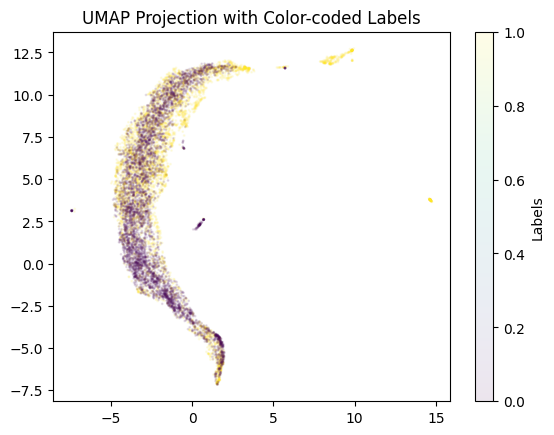

In [12]:
#Perform UMAP on these data points
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

#labels = np.array(["Randoms"] * len(latent_spaces_dict['RANDOM_IMAGES']) +
#                  ["Loops"] * len(latent_spaces_dict['LOOP_IMAGES']) +
#                  ["CNL"] * len(latent_spaces_dict['CNL_IMAGES']) +
#                  ["Chen"] * len(latent_spaces_dict['CHEN_IMAGE']) +
#                  ["ID"] * len(latent_spaces_dict['IN_DOMAIN']))

labels = np.array(["OOD"] * len(latent_spaces_dict['RANDOM_IMAGES']) +
                  ["OOD"] * len(latent_spaces_dict['LOOP_IMAGES']) +
                  ["OOD"] * len(latent_spaces_dict['CHEN_IMAGE']) +
                  ["OOD"] * len(latent_spaces_dict['CNL_IMAGES']) +
                #  ["OOD"] * len(latent_spaces_dict['OVERFOCUS_IMAGES']) +
                  ["ID"] * len(latent_spaces_dict['IN_DOMAIN']))

all_data = np.concatenate((latent_spaces_dict['RANDOM_IMAGES'], latent_spaces_dict['LOOP_IMAGES'], latent_spaces_dict['CHEN_IMAGE'], latent_spaces_dict['CNL_IMAGES'], 
                            #latent_spaces_dict["OVERFOCUS_IMAGES"], 
                            latent_spaces_dict['IN_DOMAIN']), axis=0)
print(all_data.shape)

#Dictionary with the data and labels
all_data_dict = {'data': all_data, 'labels': labels}

# Create a UMAP Model
umap_model = umap.UMAP()

# Convert string labels to numeric labels
#label_dict = {'Randoms': 0, 'Loops': 1, 'CNL': 2, 'Chen': 3, 'ID': 4}
label_dict = {'ID': 0, 'OOD': 1}
numeric_labels = np.array([label_dict[label] for label in labels])

# Fit the UMAP model to the data
umap_result = umap_model.fit_transform(all_data)

# Plot the UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=numeric_labels, cmap='viridis', s=1, alpha=0.1)
plt.title('UMAP Projection with Color-coded Labels')
plt.colorbar(label='Labels')
plt.show()



Accuracy: 0.7168
Precision: 0.7450
Recall: 0.7209


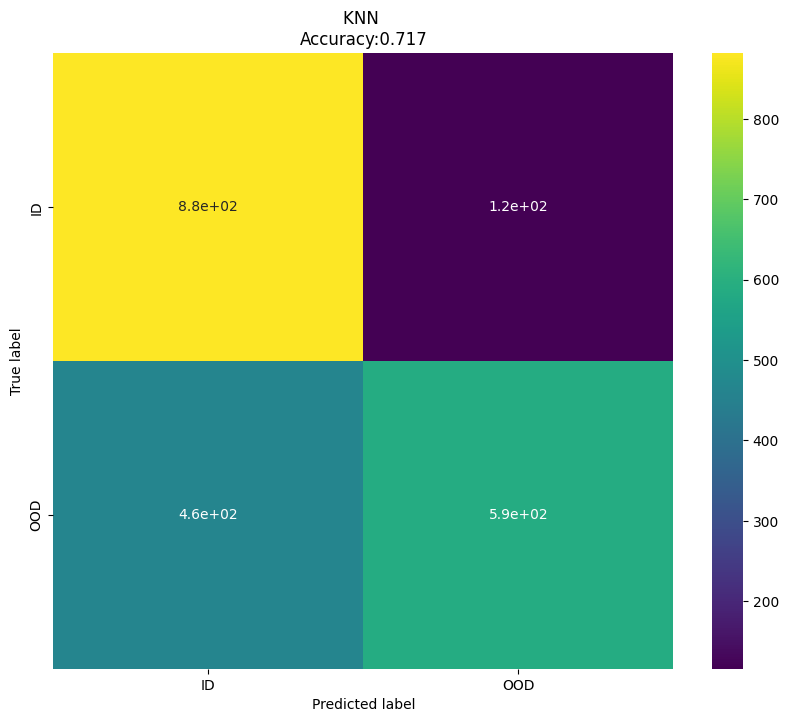

In [15]:
#Use Nearest Neighbors on the all_data_dict with the array values for all the 16 dimensional vectors with the different labels present

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_data_dict['data'], all_data_dict['labels'], test_size=0.2, random_state=42)

# Create a Nearest Neighbors model
n_neighbors = 3
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn_model.predict(X_test)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#Make the Confusion Matrix for the predictions
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of labels
labels = ['ID', 'OOD']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Create a DataFrame from the confusion matrix  
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('KNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Committee Voting - 256 points IN/OUT domain

(10240, 16)


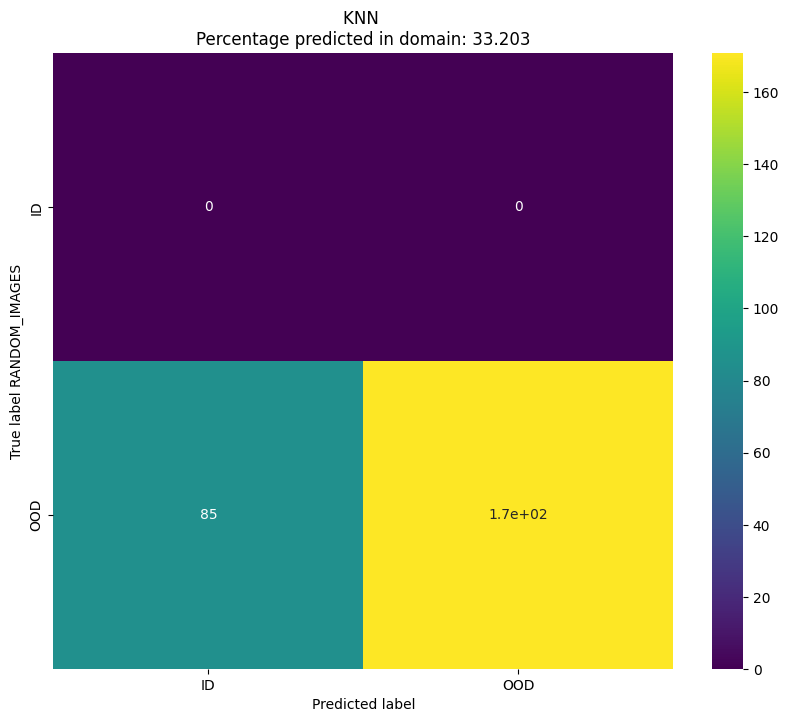

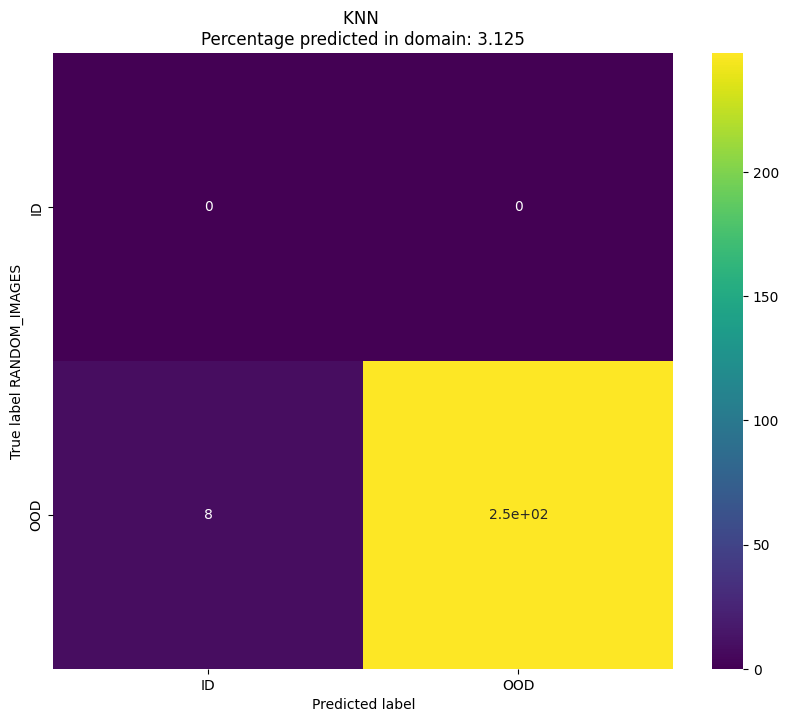

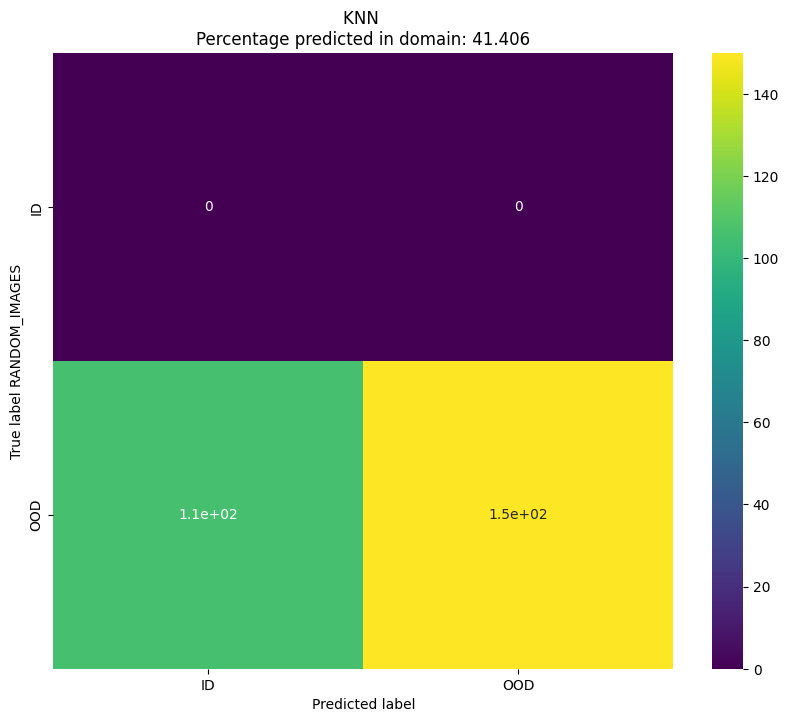

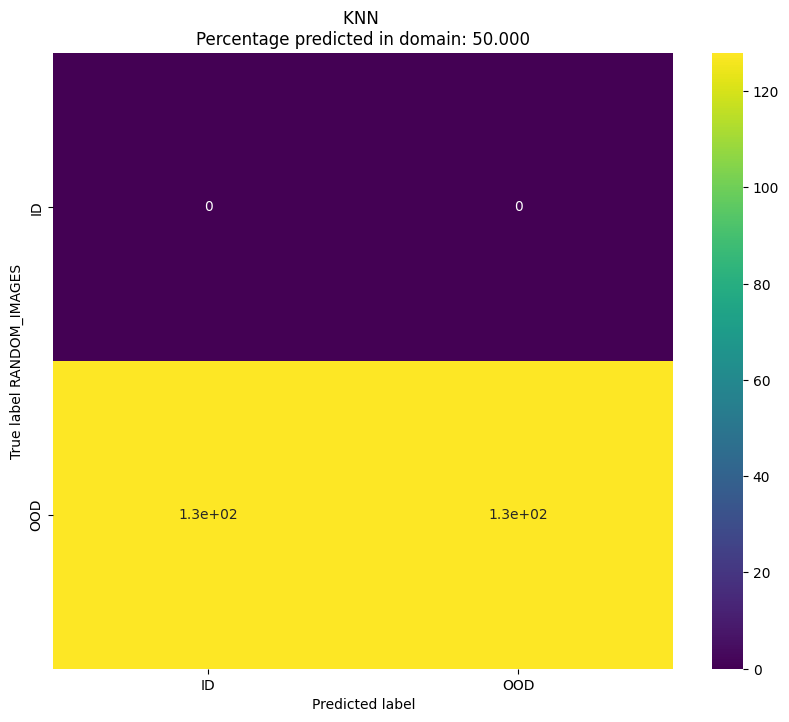

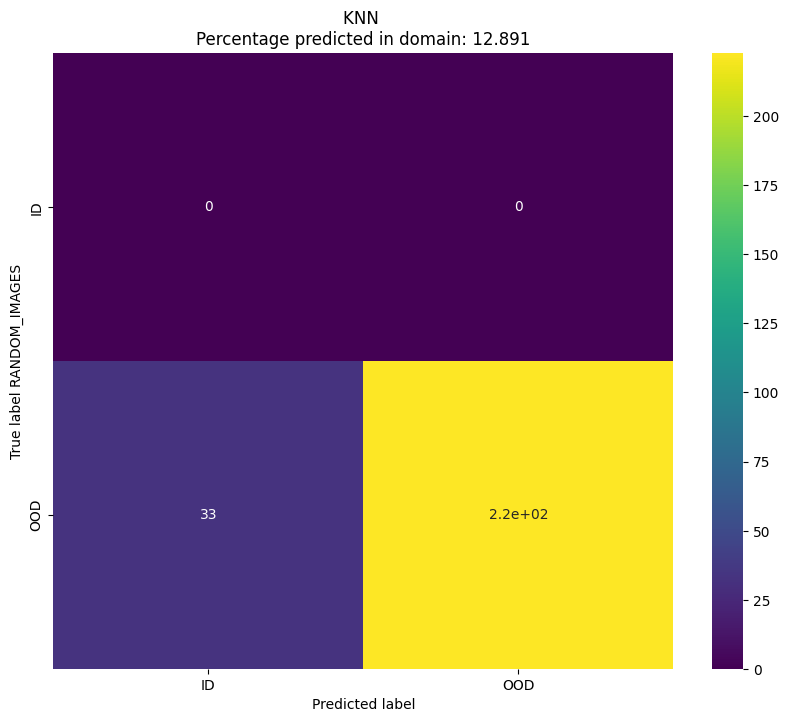

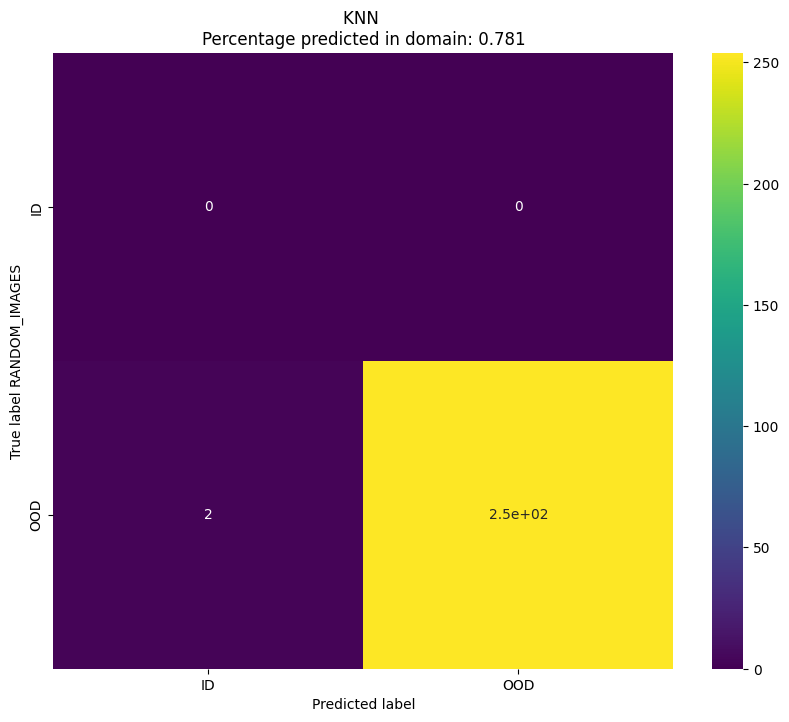

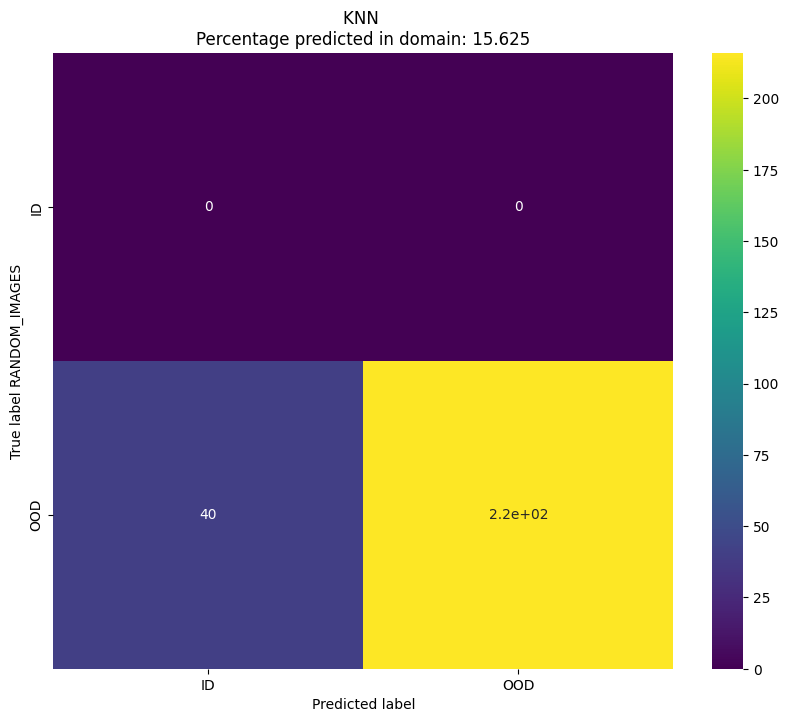

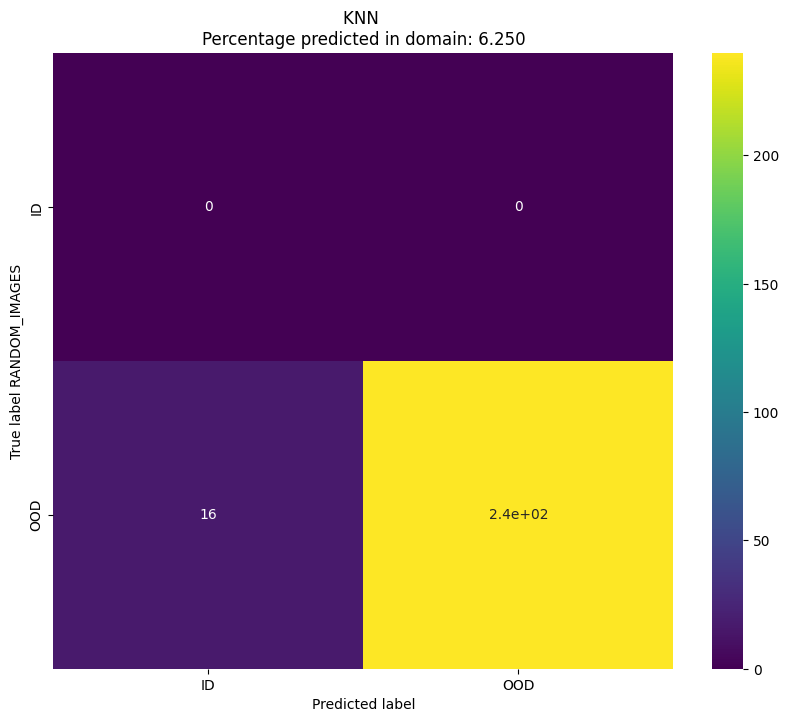

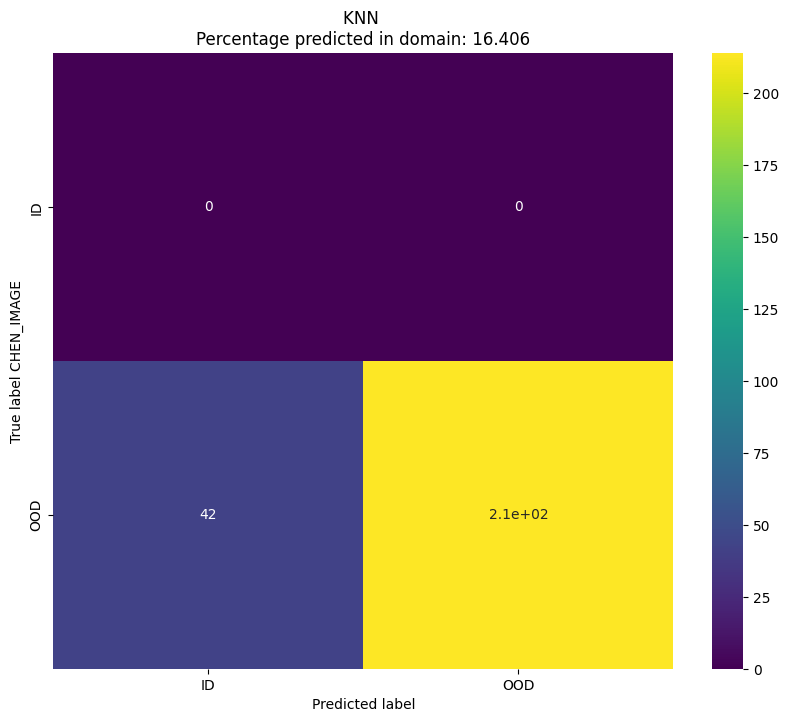

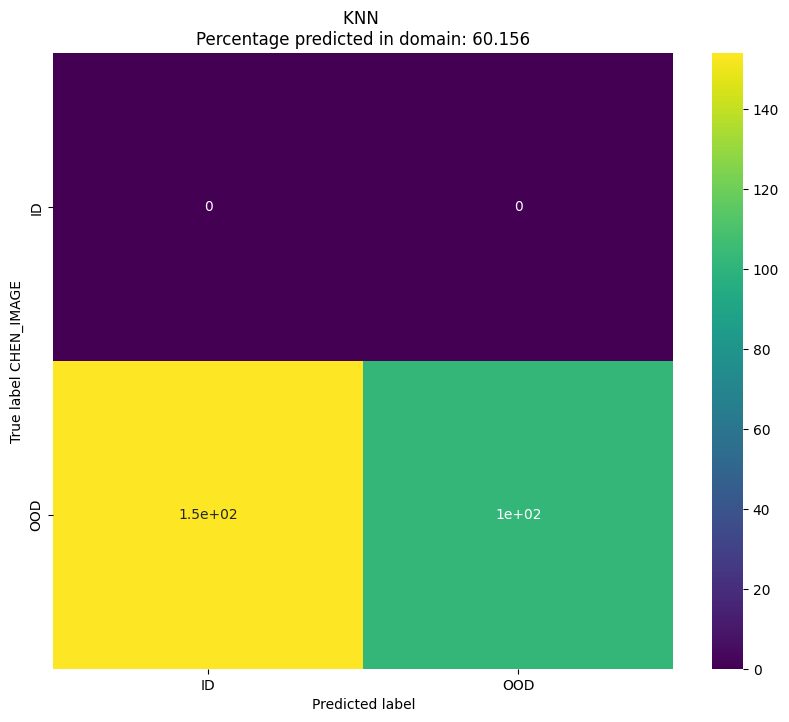

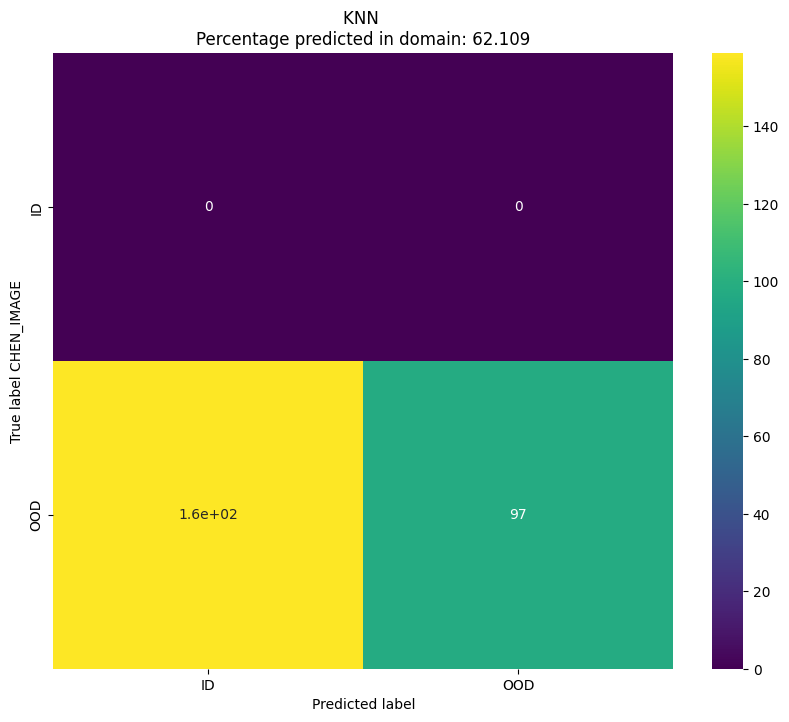

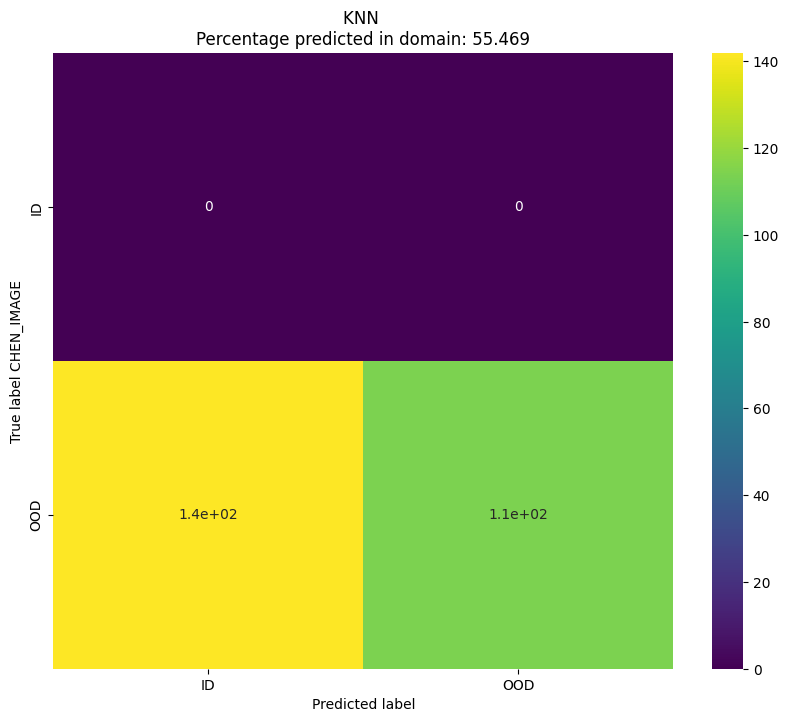

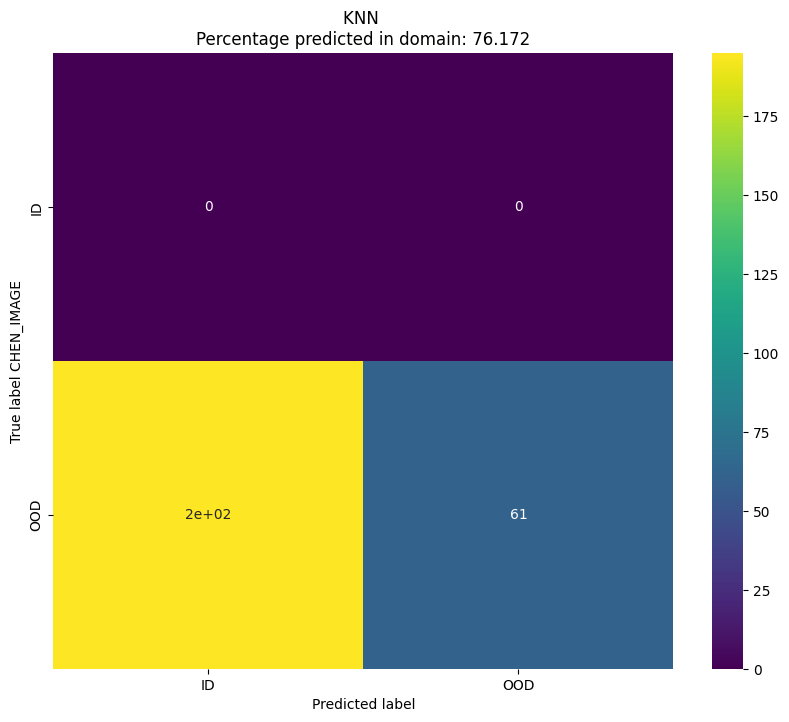

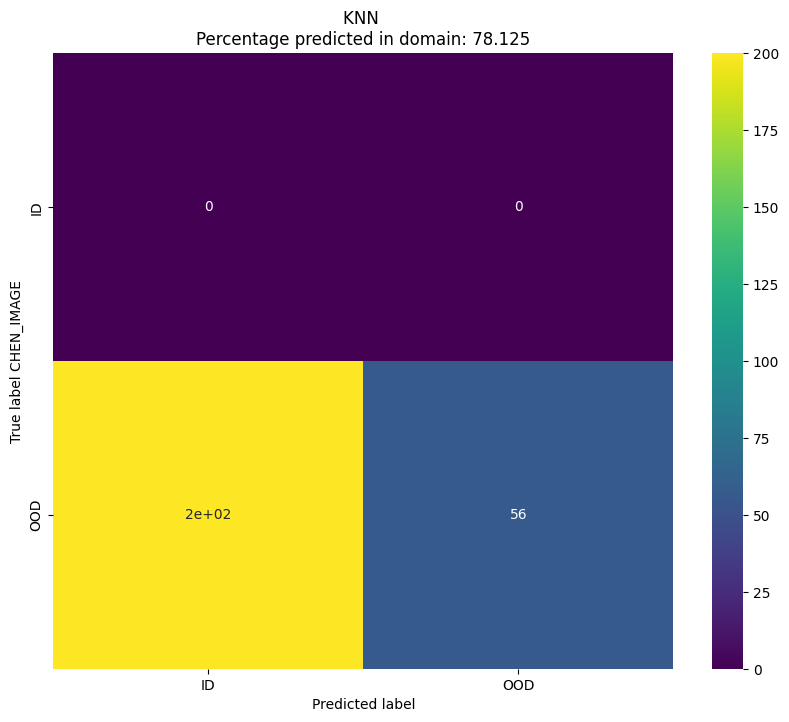

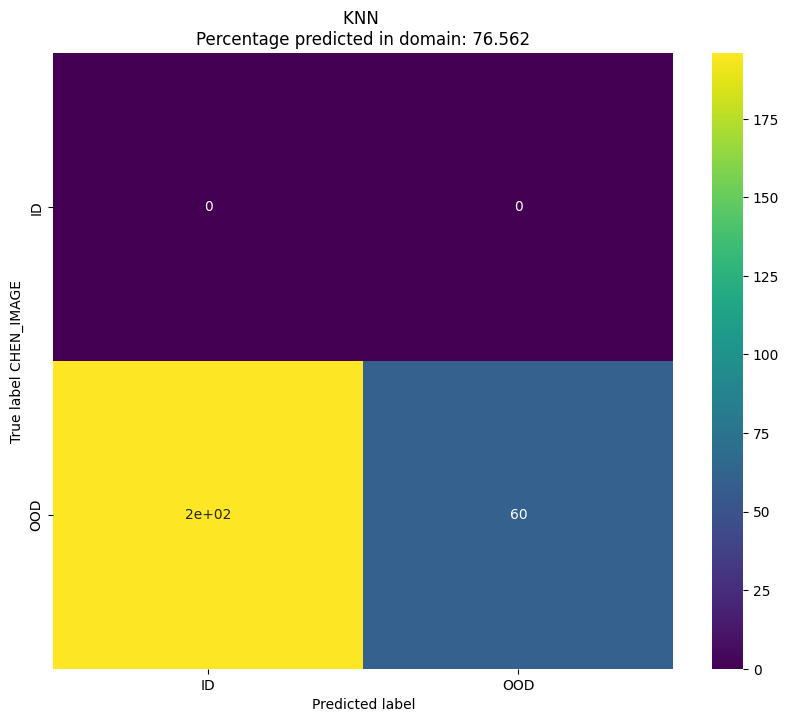

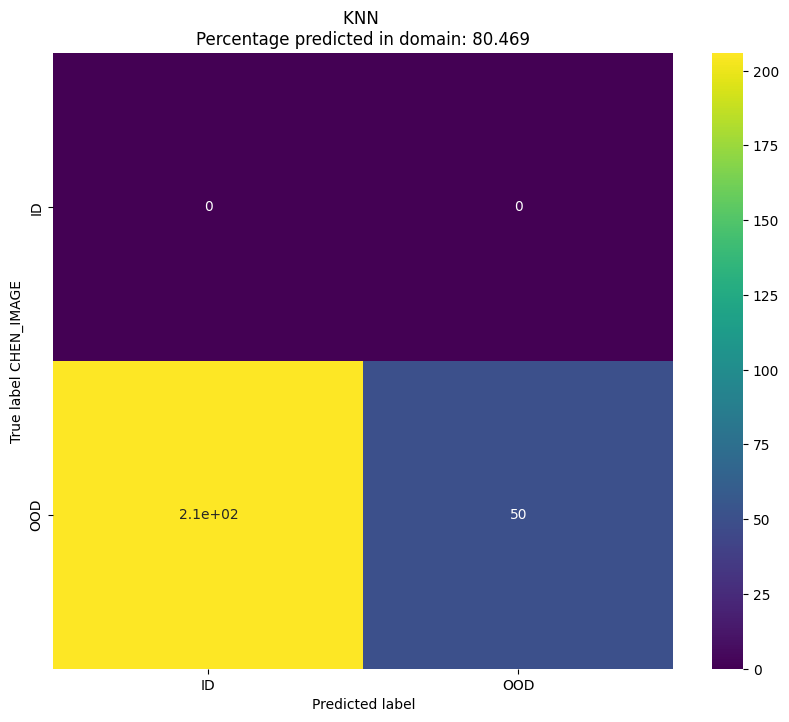

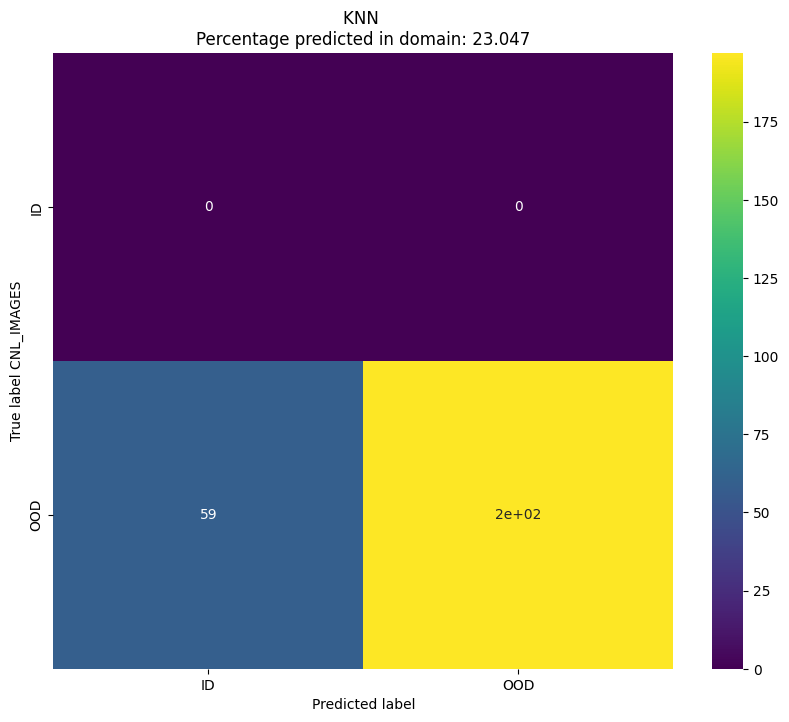

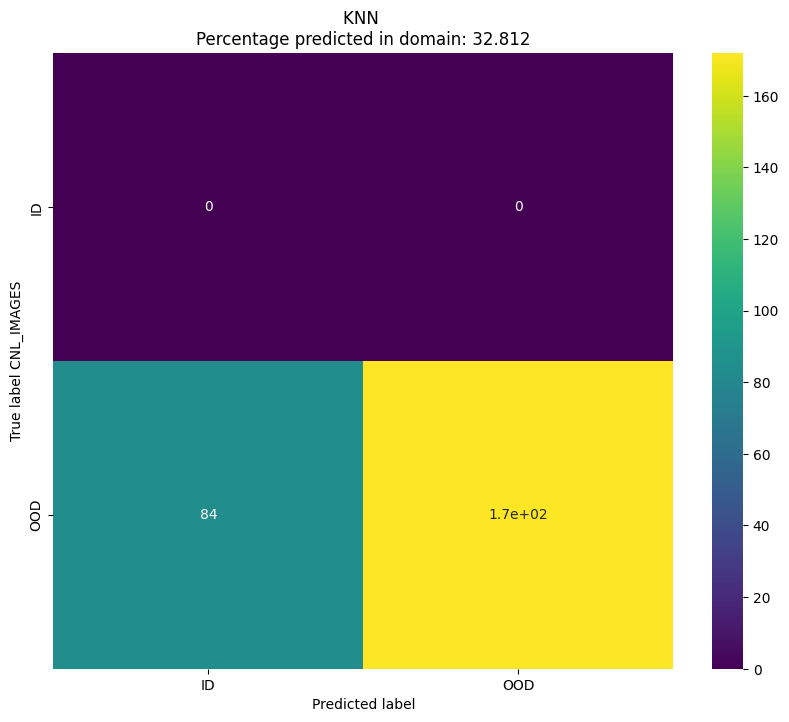

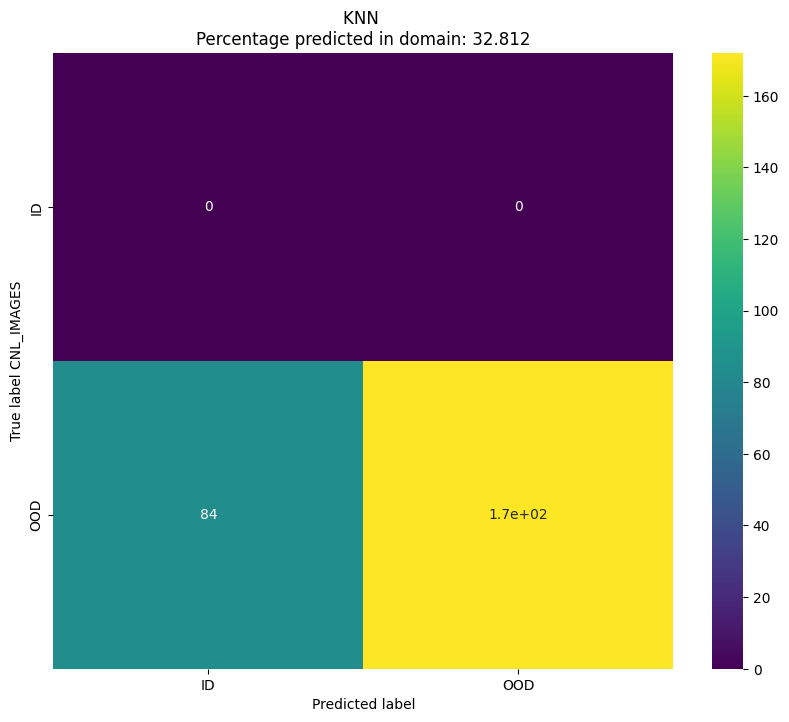

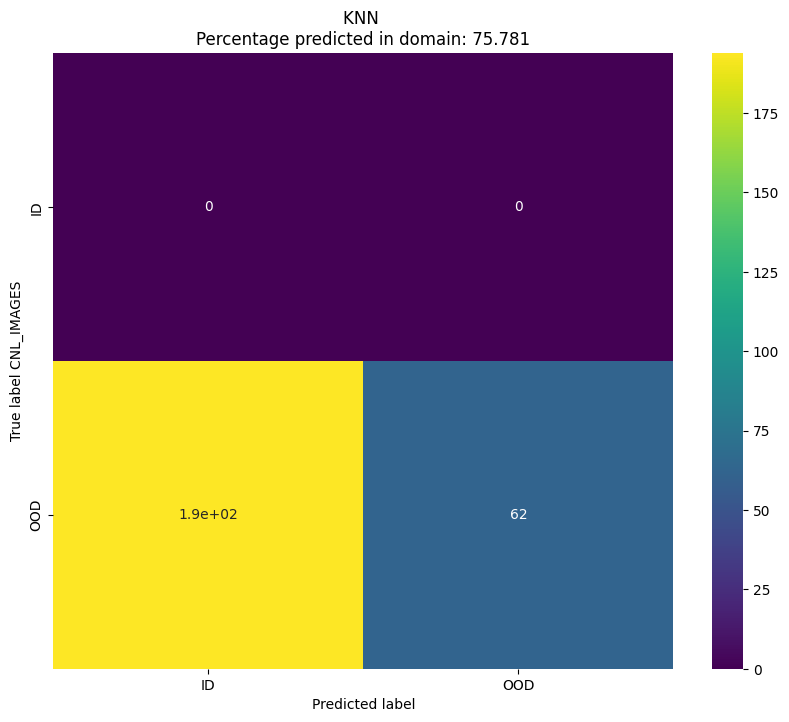

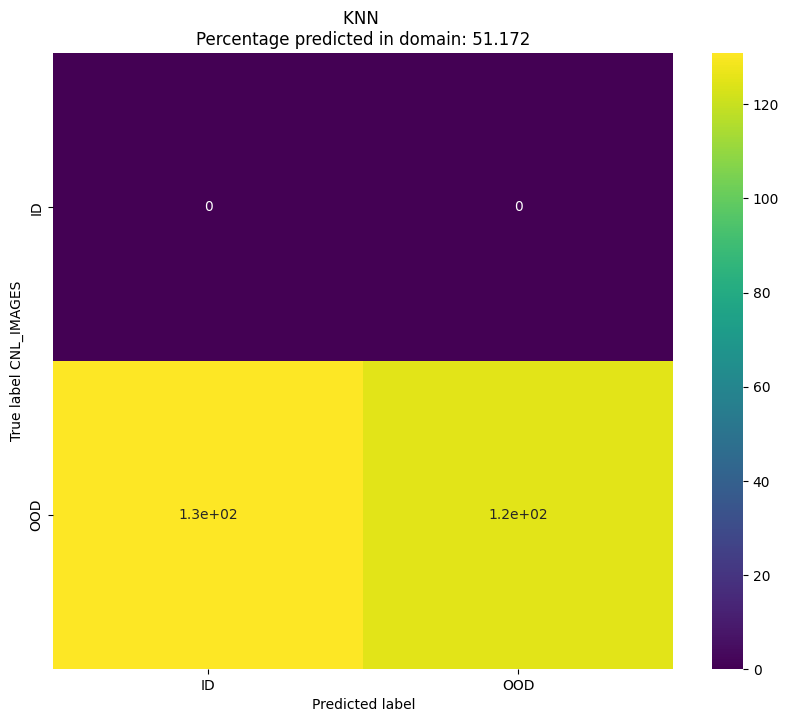

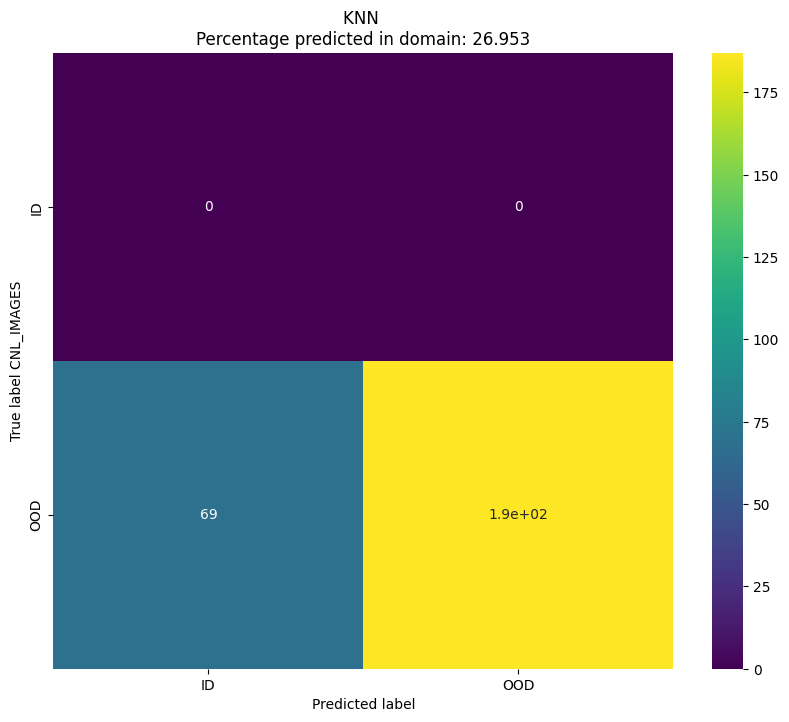

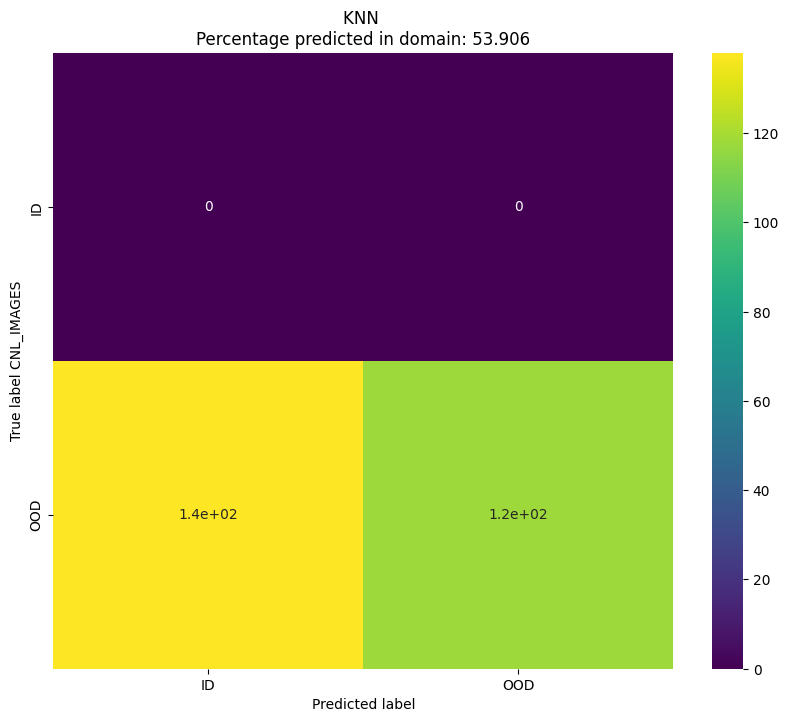

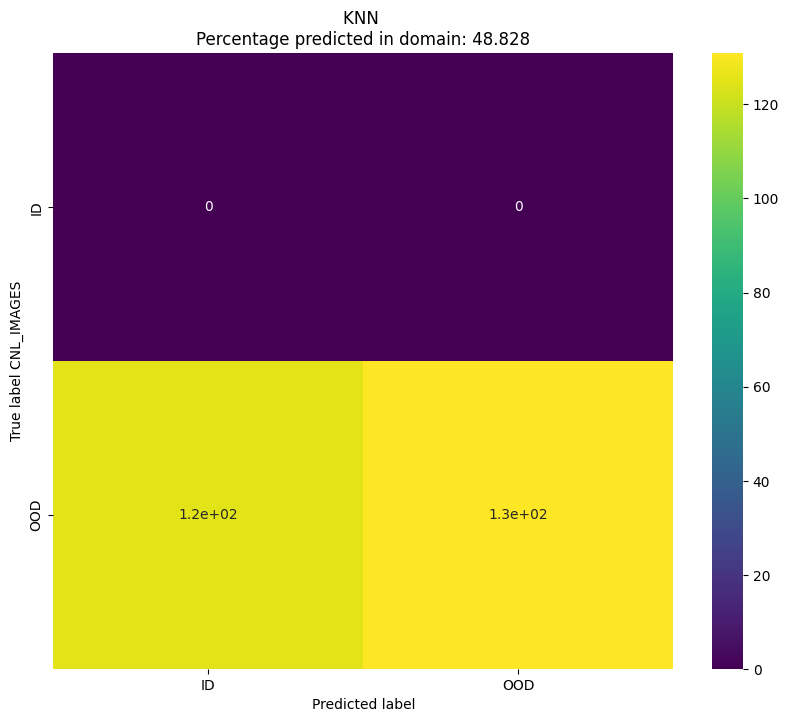

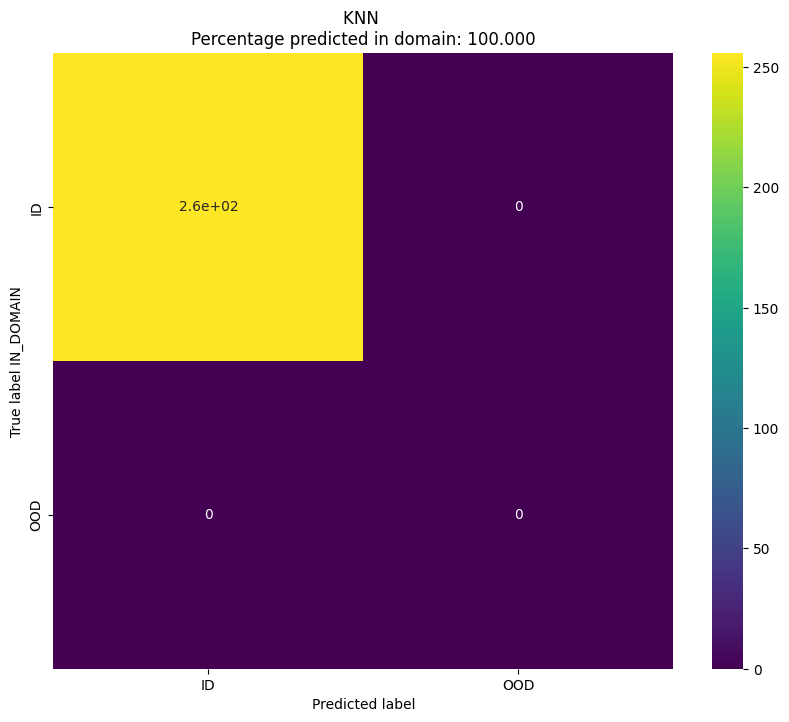

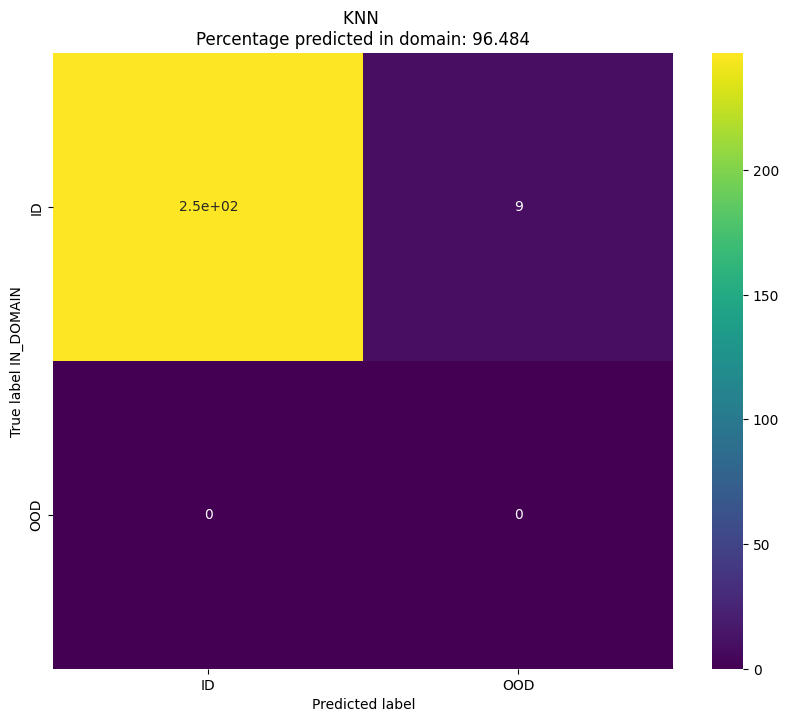

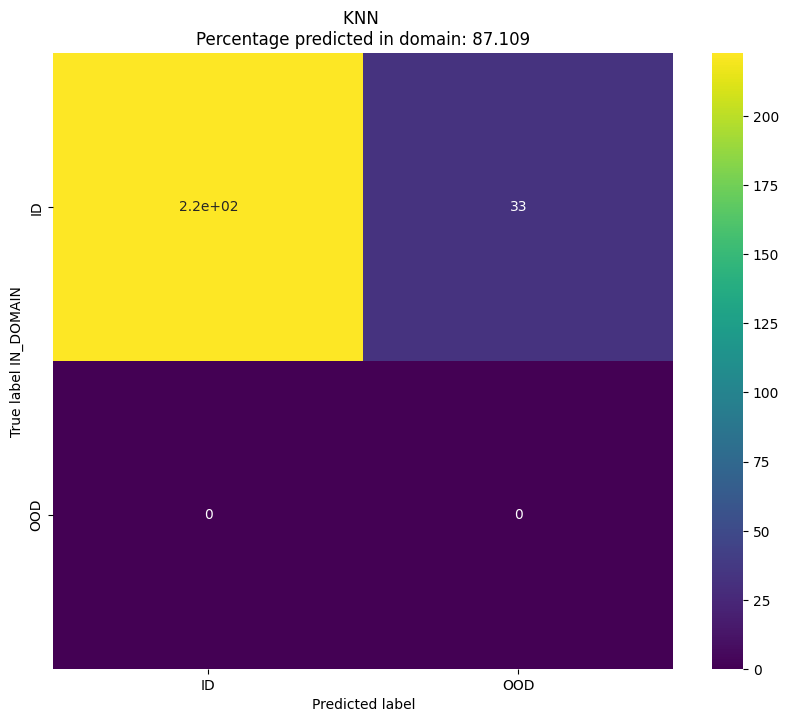

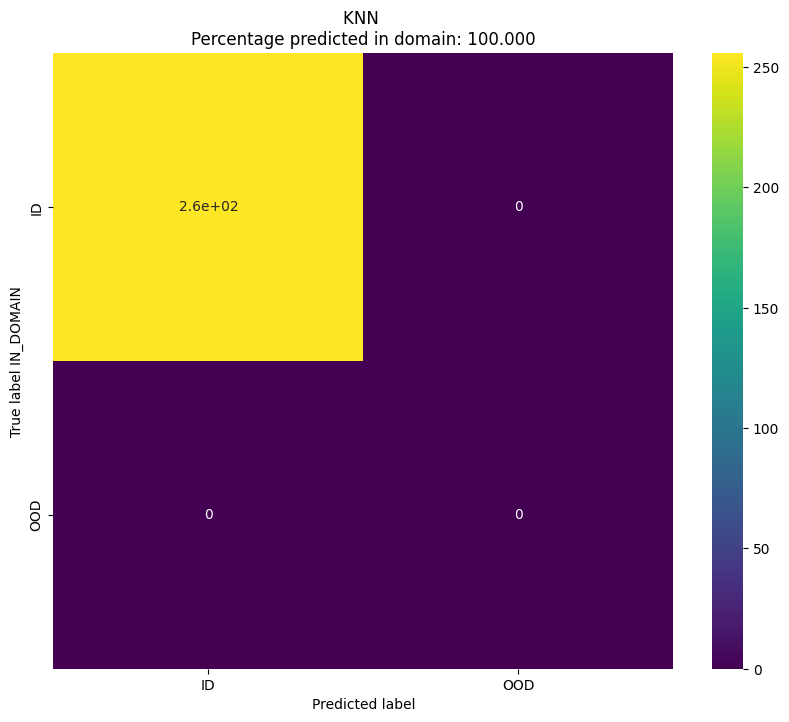

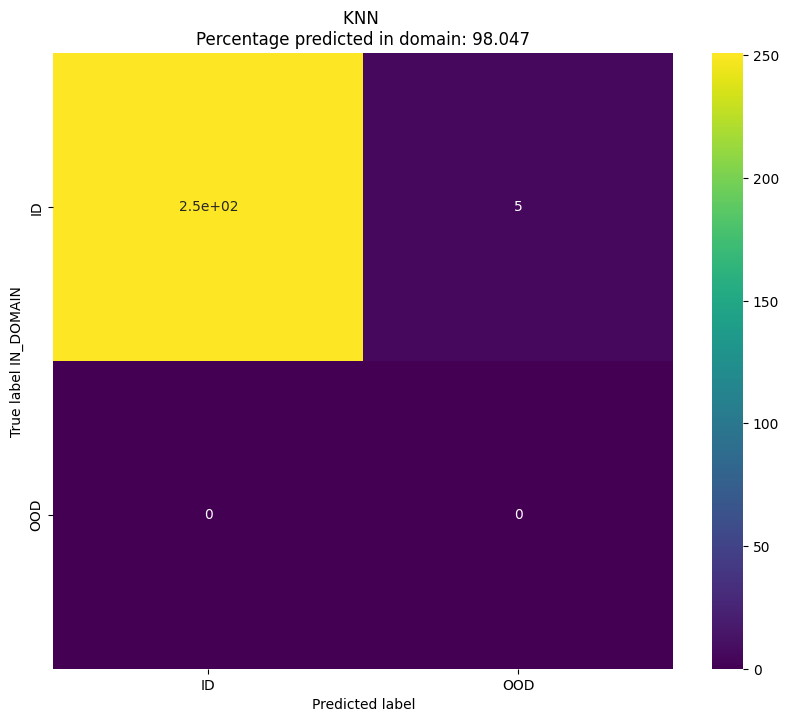

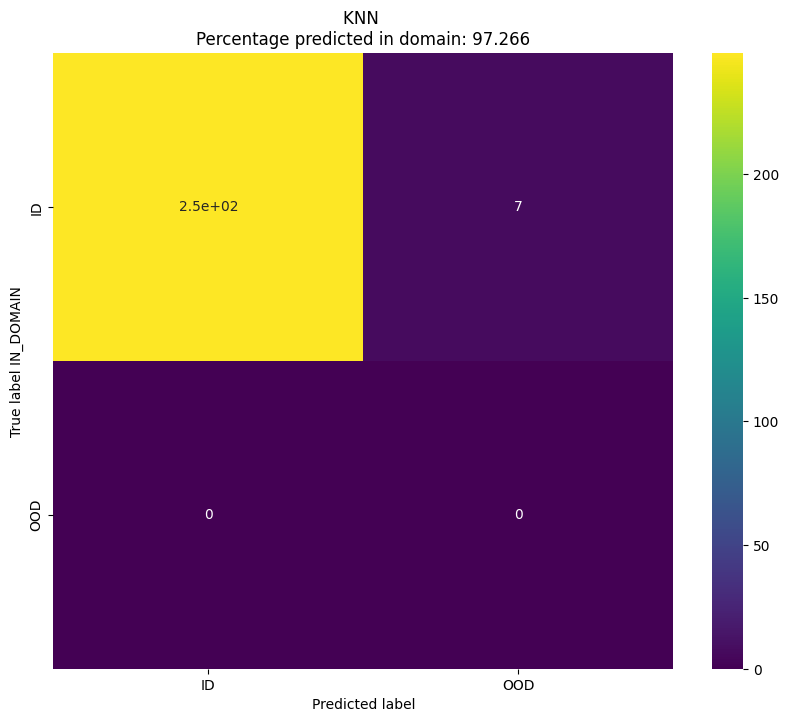

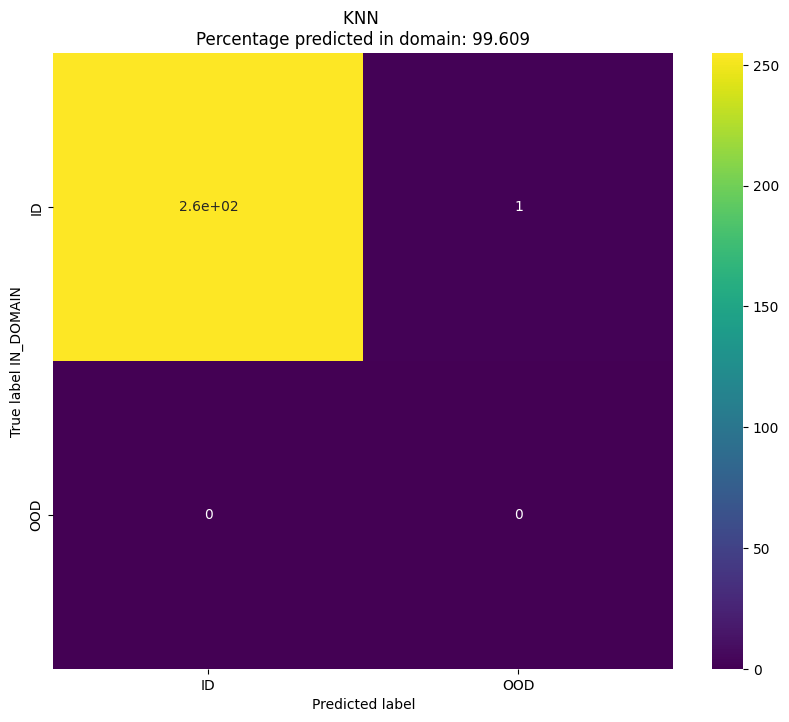

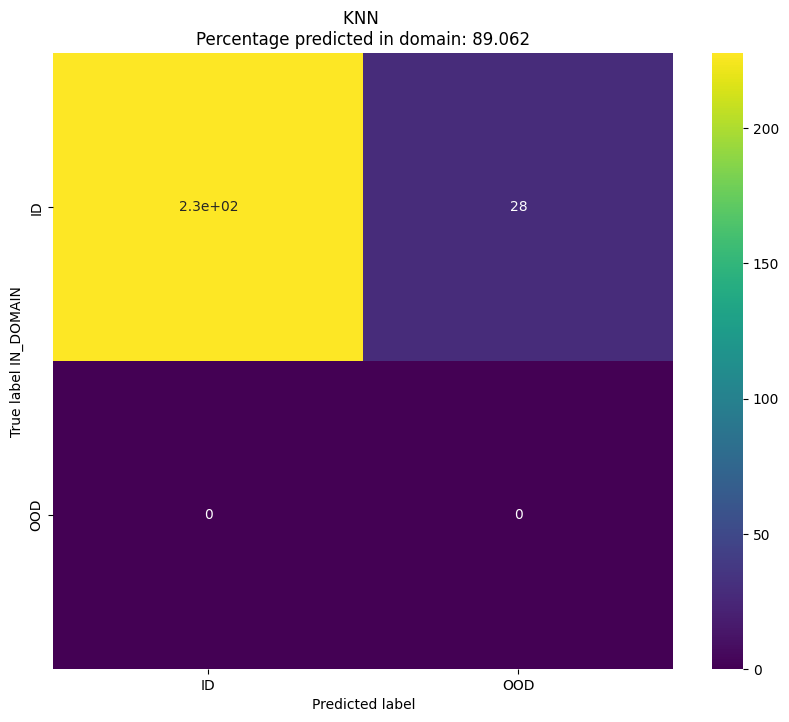

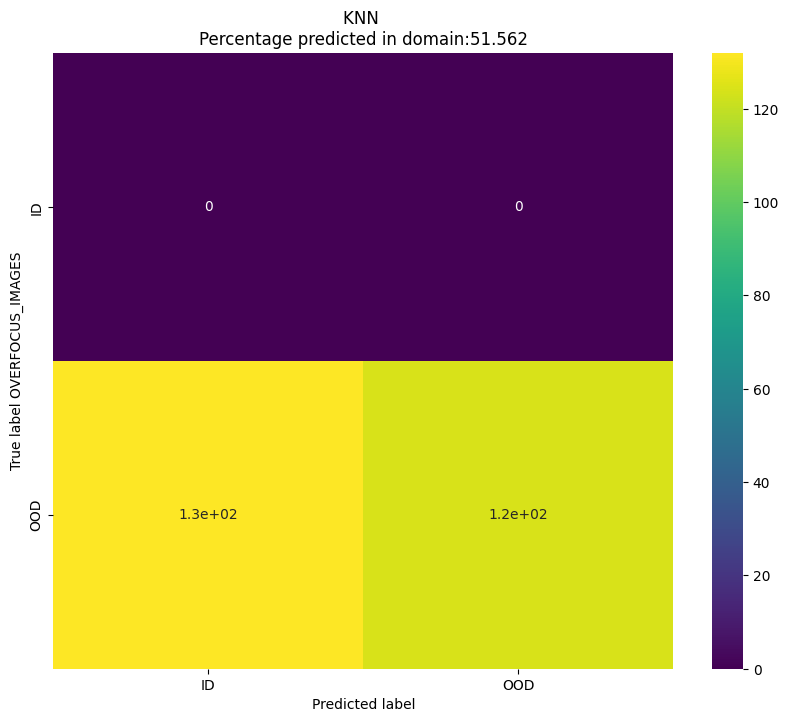

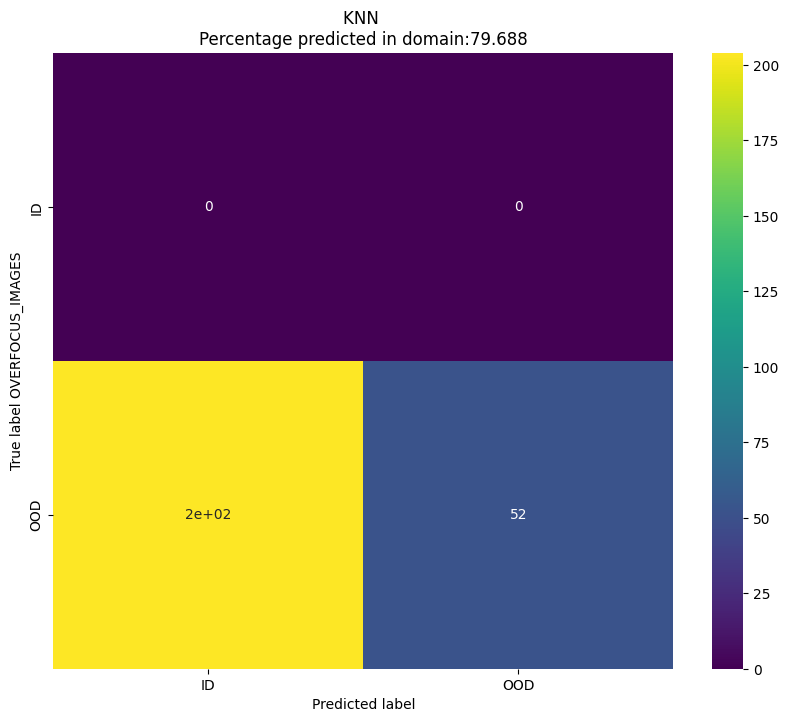

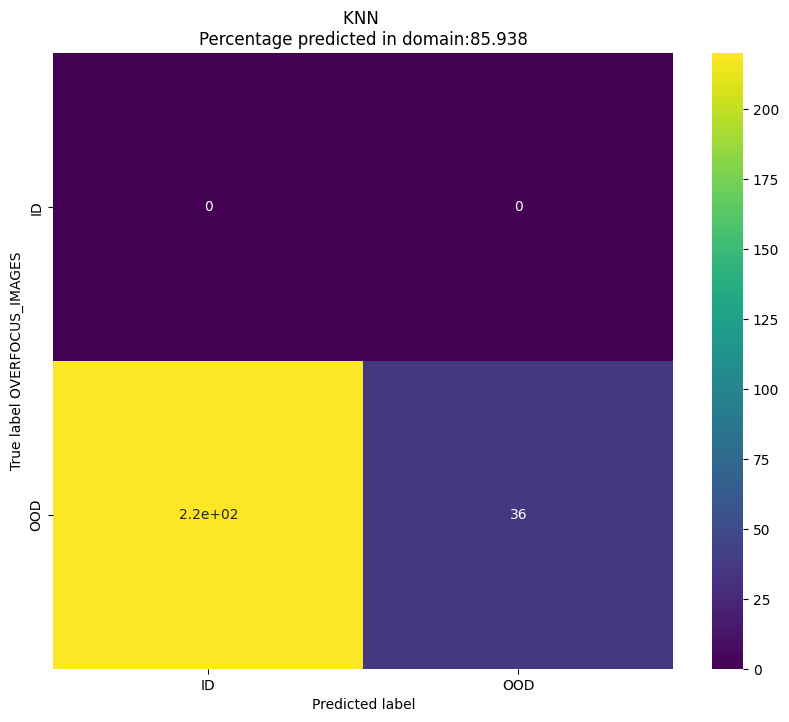

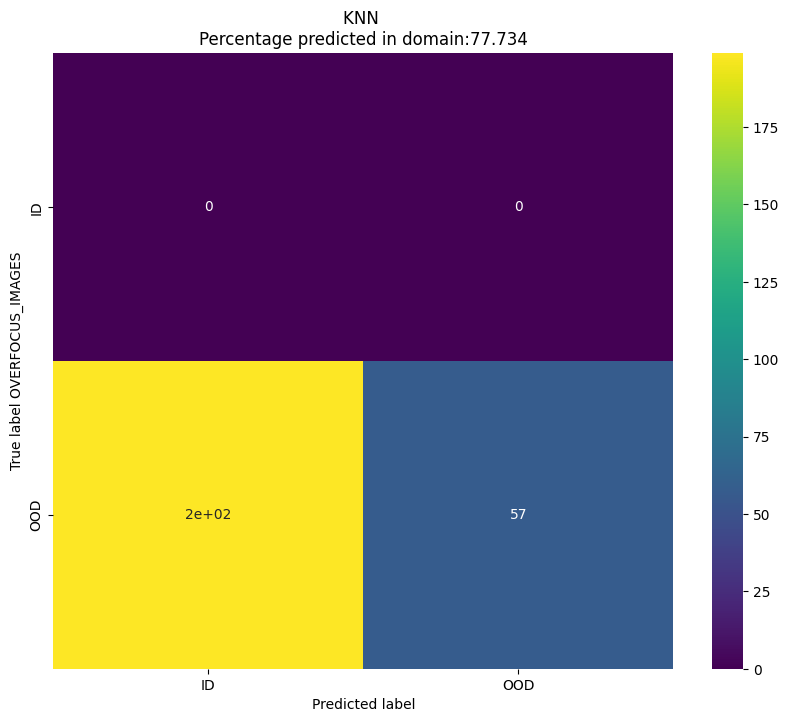

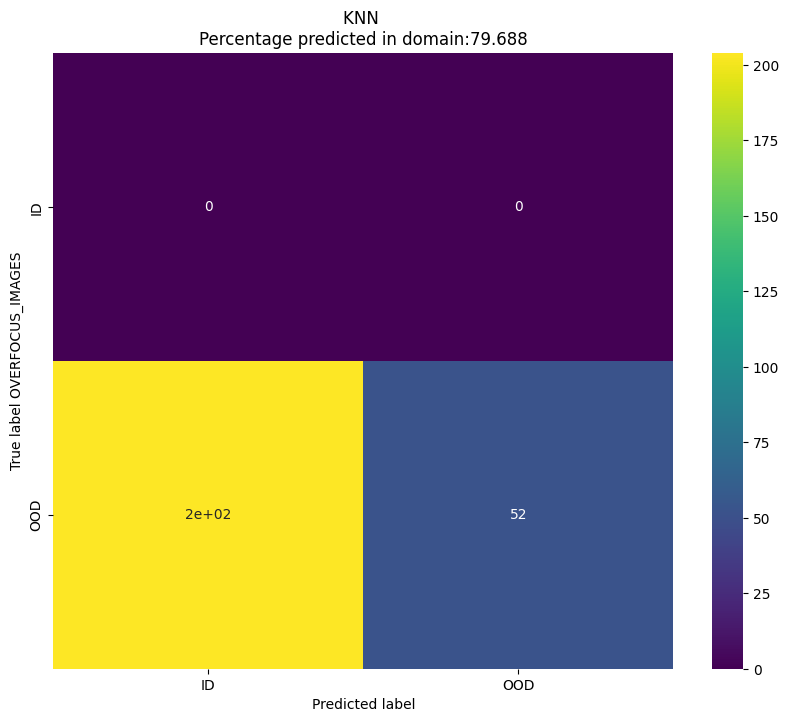

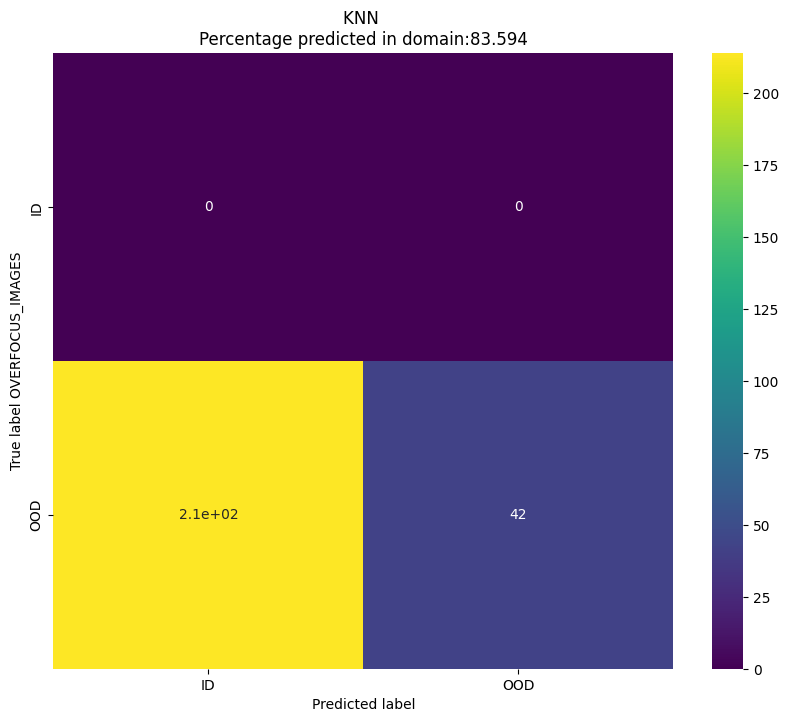

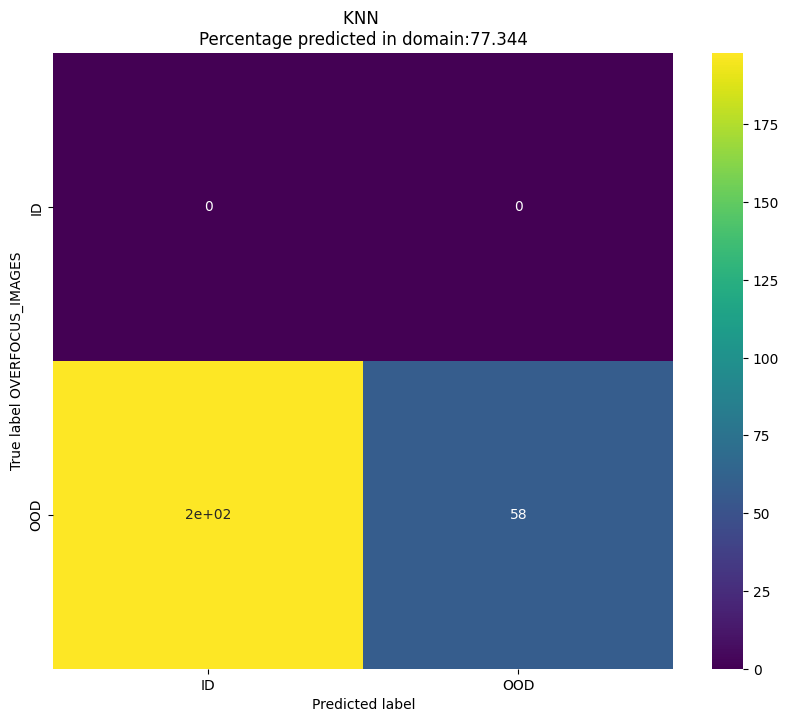

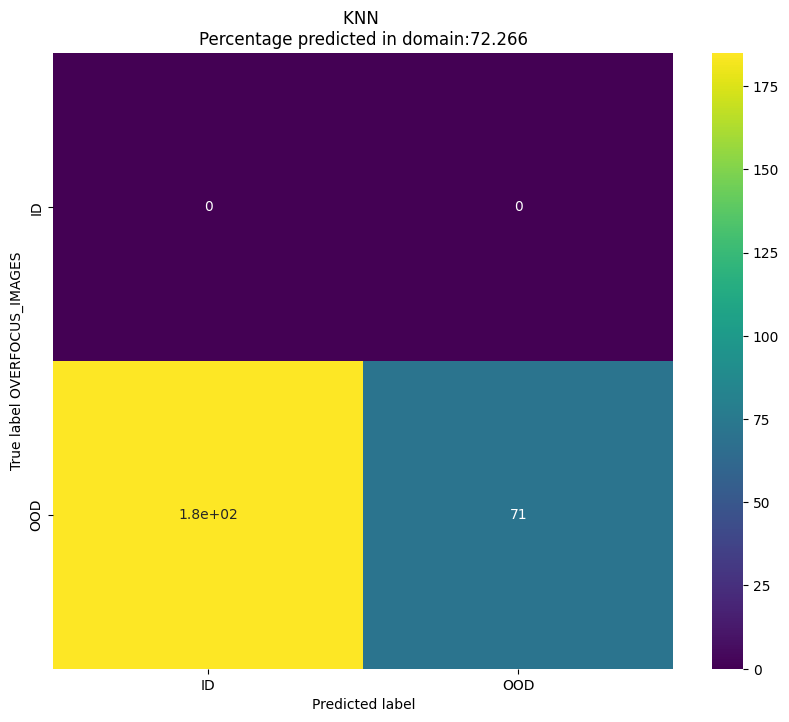

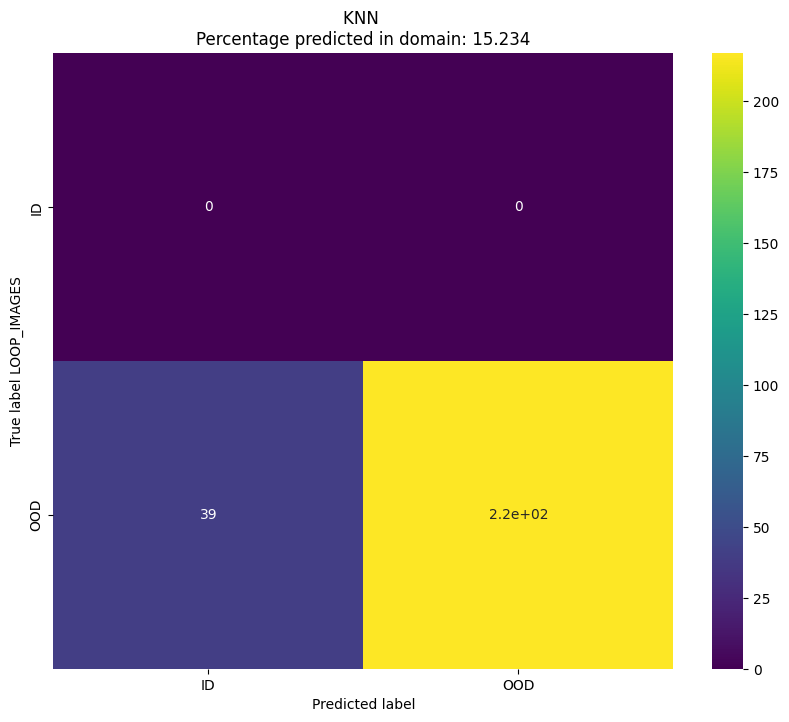

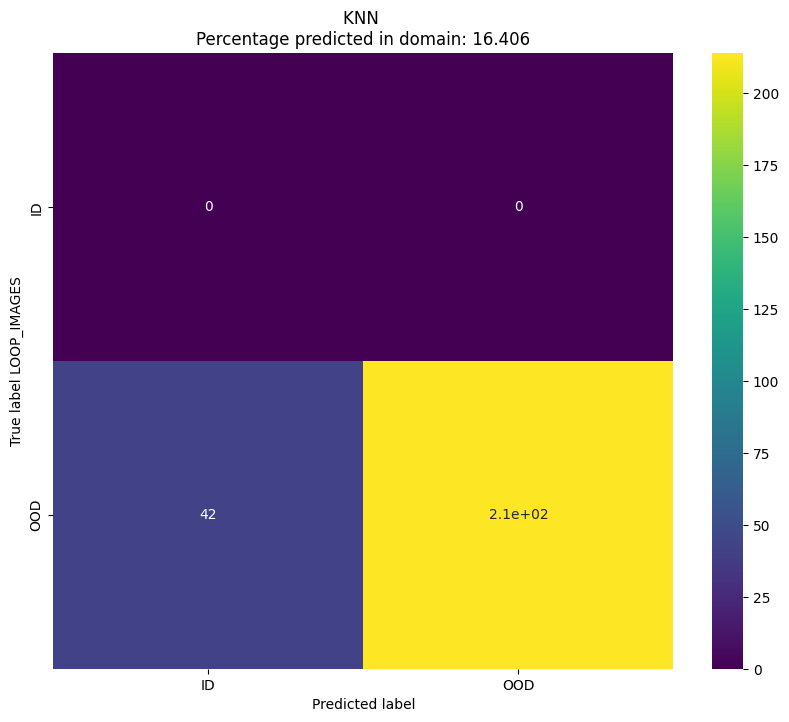

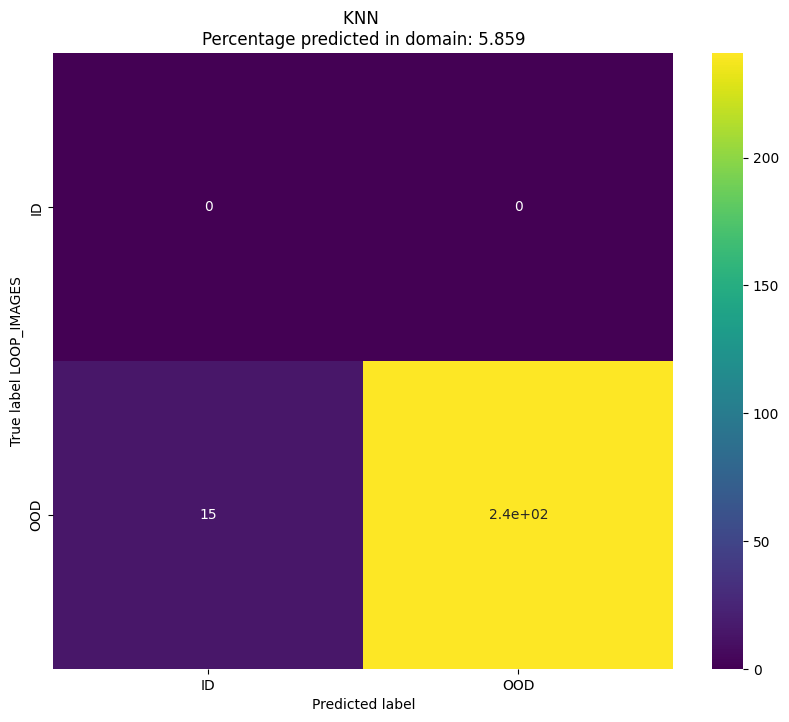

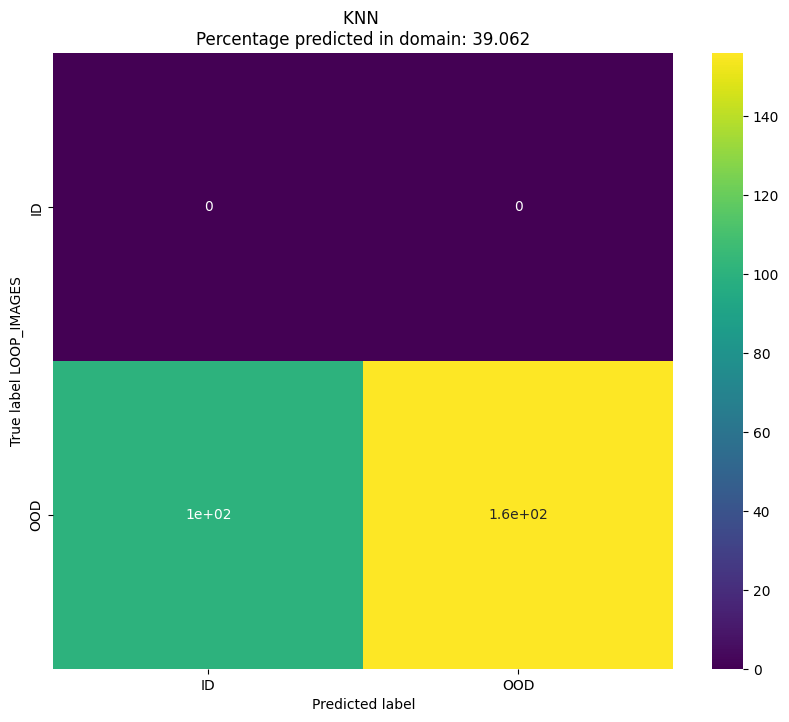

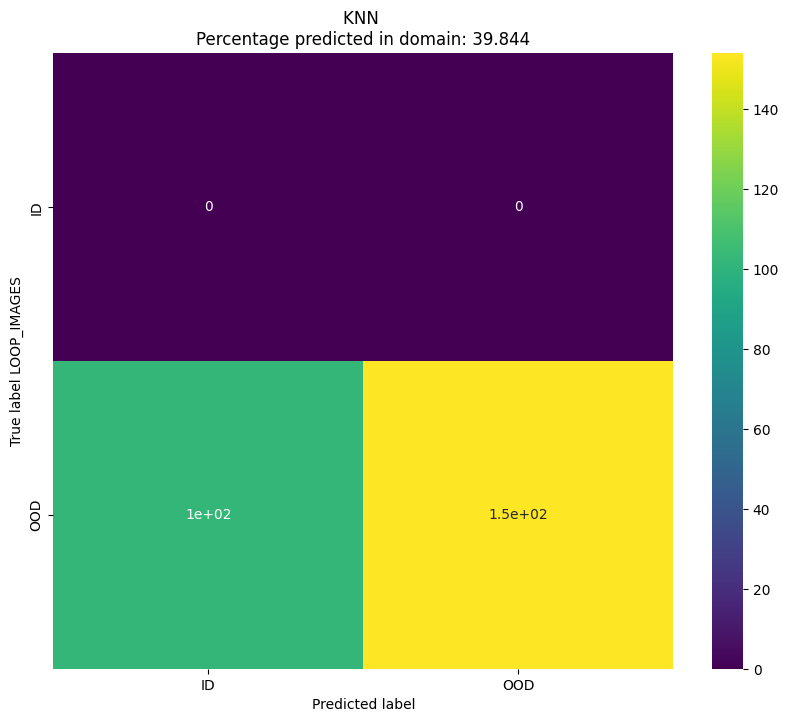

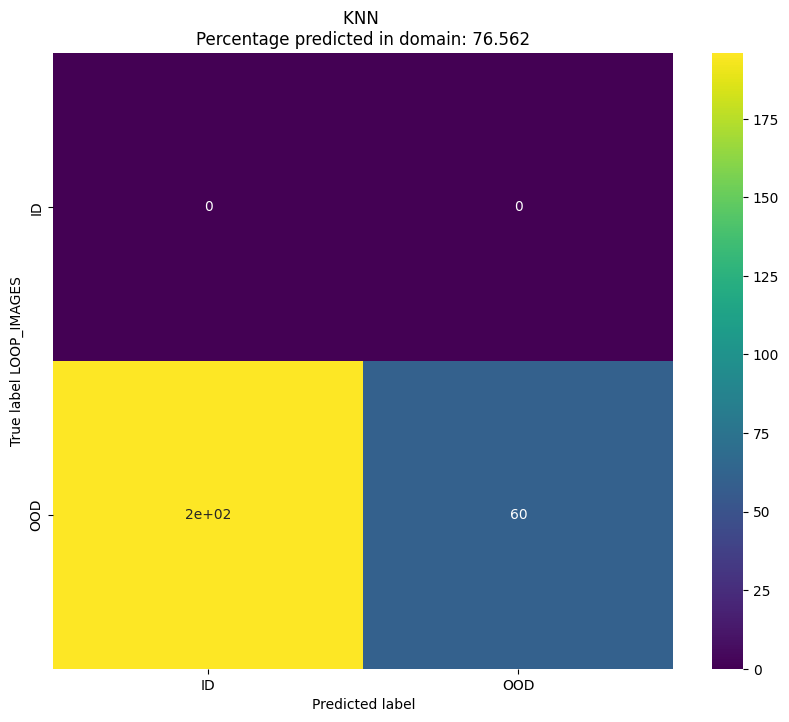

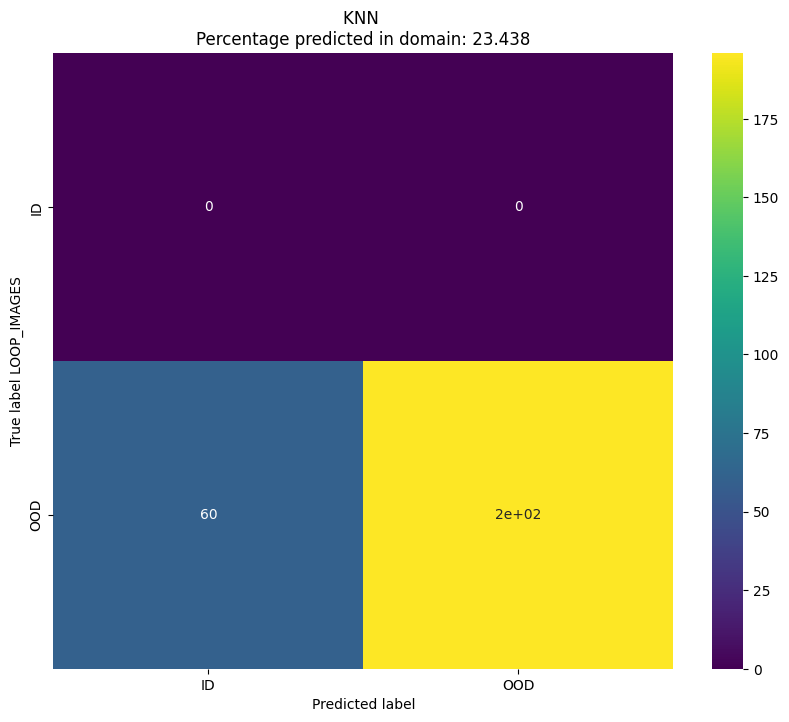

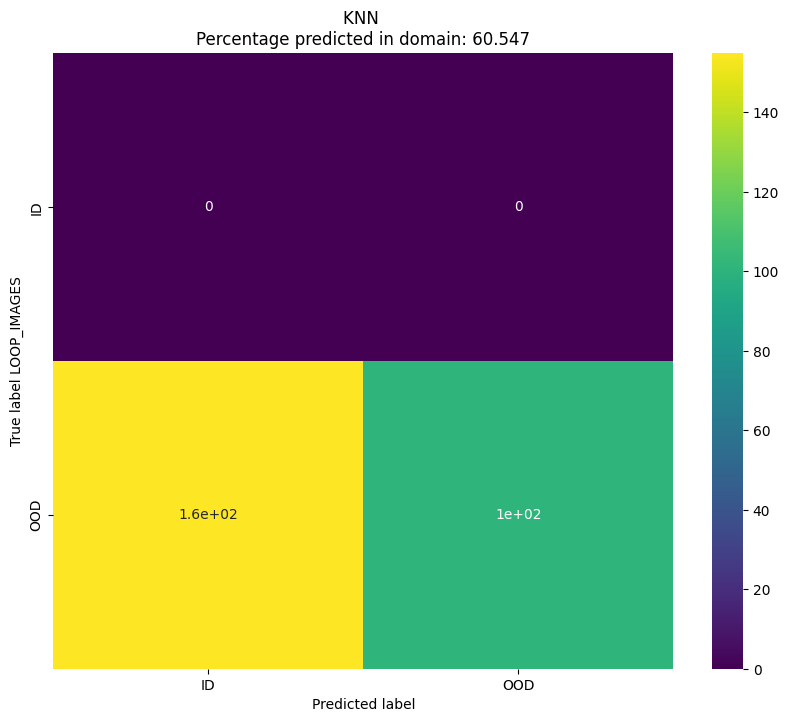

{'CNL_IMAGES': [0.23046875, 0.328125, 0.328125, 0.7578125, 0.51171875, 0.26953125, 0.5390625, 0.48828125], 'LOOP_IMAGES': [0.15234375, 0.1640625, 0.05859375, 0.390625, 0.3984375, 0.765625, 0.234375, 0.60546875], 'RANDOM_IMAGES': [0.33203125, 0.03125, 0.4140625, 0.5, 0.12890625, 0.0078125, 0.15625, 0.0625], 'CHEN_IMAGE': [0.1640625, 0.6015625, 0.62109375, 0.5546875, 0.76171875, 0.78125, 0.765625, 0.8046875], 'IN_DOMAIN': [1.0, 0.96484375, 0.87109375, 1.0, 0.98046875, 0.97265625, 0.99609375, 0.890625], 'OVERFOCUS_IMAGES': [0.515625, 0.796875, 0.859375, 0.77734375, 0.796875, 0.8359375, 0.7734375, 0.72265625]}


/var/folders/0p/5863bbd96mzdqdxzvjnhg7sr0000gn/T/ipykernel_3373/3008111482.py:133: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  g = sns.violinplot(data=df, ax=ax, palette='Spectral', cut=0, scale='width', inner='quartile', orient="h")


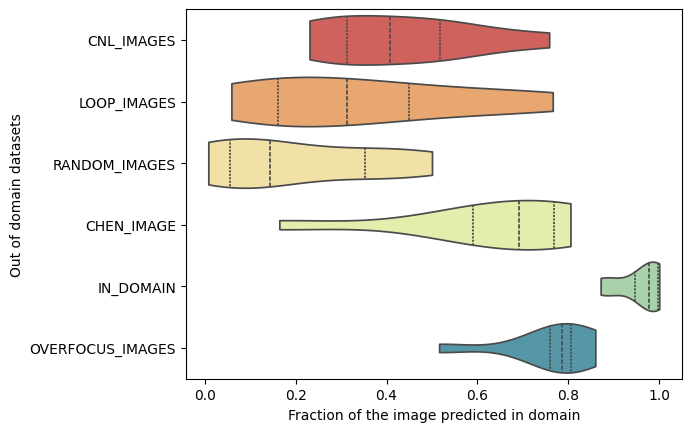

In [16]:
# Calculating the vectors for all the out of domain images now
# Create a dictionary to store the variables

import random

RANDOM_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/random_images'
LOOPS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/loops_images'
CHEN_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_chen'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_CNL_cleaned/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/val'



from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(all_data_dict['data'].shape)
X_train = all_data_dict['data']
y_train = all_data_dict['labels']
# Create a Nearest Neighbors model
n_neighbors = 3
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

#Define the dictionary
Fractions = {"CNL_IMAGES":[], "LOOP_IMAGES":[], "RANDOM_IMAGES":[], "CHEN_IMAGE":[], "IN_DOMAIN":[], "OVERFOCUS_IMAGES":[]}

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

for imagepath in [RANDOM_IMAGE_PATH, CHEN_IMAGE_PATH, CNL_UNDEROVERFOCUS_IMAGE_PATH, VAL_UNDERFOCUS_IMAGE_PATH, TRAIN_OVERFOCUS_PATH, LOOPS_IMAGE_PATH]:
  filename  = glob.glob(imagepath + "/*")
  if Name_dict[imagepath] not in latent_spaces_dict:
    latent_spaces_dict[Name_dict[imagepath]] = torch.zeros(0)
  if imagepath == TRAIN_OVERFOCUS_PATH:
    for i in range(10, 18):
      image_tensor = load_resize_and_divide_image(filename[i])
      image_tensor = image_tensor.permute(0, 3, 1, 2)
      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))
      y_pred = knn_model.predict(all_outdomain_latentspaces)
      if(Name_dict[imagepath] == "IN_DOMAIN"):
        y_test = np.array(["ID"] * len(all_outdomain_latentspaces))
      else:
        y_test = np.array(["OOD"] * len(all_outdomain_latentspaces))
      # Compute the confusion matrix
      cm = confusion_matrix(y_test, y_pred, labels=labels)

      # Create a DataFrame from the confusion matrix
      cm_df = pd.DataFrame(cm, index=labels, columns=labels)

      # Create a heatmap from the confusion matrix
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm_df, annot=True, cmap='viridis')
      if Name_dict[imagepath] == "IN_DOMAIN":
        in_domain_percentage = accuracy_score(y_test, y_pred)
      else:
        in_domain_percentage = (1 - accuracy_score(y_test, y_pred))
      
      Fractions[Name_dict[imagepath]].append(in_domain_percentage)

      plt.title('KNN \nPercentage predicted in domain:{0:.3f}'.format(in_domain_percentage*100))
      plt.ylabel(f'True label {Name_dict[imagepath]}')
      plt.xlabel('Predicted label')
      plt.show()
  else:
    for i in range(2, 10):
      image_tensor = load_resize_and_divide_image(filename[i])
      image_tensor = image_tensor.permute(0, 3, 1, 2)

      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))
      y_pred = knn_model.predict(all_outdomain_latentspaces)
      if(Name_dict[imagepath] == "IN_DOMAIN"):
        y_test = np.array(["ID"] * len(all_outdomain_latentspaces))
      else:
        y_test = np.array(["OOD"] * len(all_outdomain_latentspaces))
      # Compute the confusion matrix
      cm = confusion_matrix(y_test, y_pred, labels=labels)

      # Create a DataFrame from the confusion matrix
      cm_df = pd.DataFrame(cm, index=labels, columns=labels)

      if Name_dict[imagepath] == "IN_DOMAIN":
        in_domain_percentage = accuracy_score(y_test, y_pred)
      else:
        in_domain_percentage = (1 - accuracy_score(y_test, y_pred))
      
      Fractions[Name_dict[imagepath]].append(in_domain_percentage)

      # Create a heatmap from the confusion matrix
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm_df, annot=True, cmap='viridis')
      plt.title('KNN \nPercentage predicted in domain: {0:.3f}'.format(in_domain_percentage*100))
      plt.ylabel(f'True label {Name_dict[imagepath]}')
      plt.xlabel('Predicted label')
      plt.show()
    
print(Fractions)

#Make a violin plot for the different percentages for the Fractions dictionary
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl

fig, ax = pl.subplots()

df = pd.DataFrame({key: pd.Series(value) for key, value in Fractions.items()})
#Set x and y labels
ax.set_xlabel("Fraction of the image predicted in domain")
ax.set_ylabel("Out of domain datasets")

g = sns.violinplot(data=df, ax=ax, palette='Spectral', cut=0, scale='width', inner='quartile', orient="h")
pl.show()





In [17]:
all_vectors.size()

torch.Size([25395, 16])

Trying out KDE estimates

torch.Size([25395, 16])
Printing the starting training images


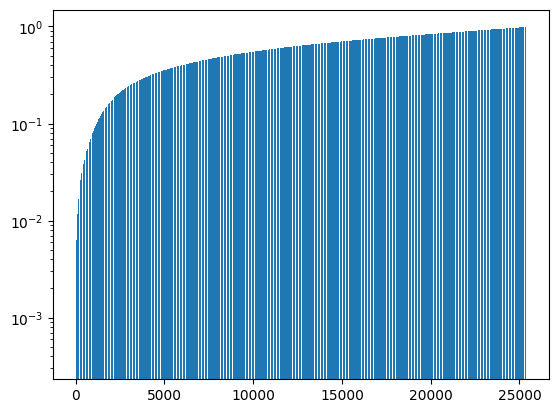

/var/folders/0p/5863bbd96mzdqdxzvjnhg7sr0000gn/T/ipykernel_83137/1738263837.py:201: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  g = sns.violinplot(data=df, ax=ax, palette='Spectral', cut=0, scale='width', inner='quartile', orient="h")


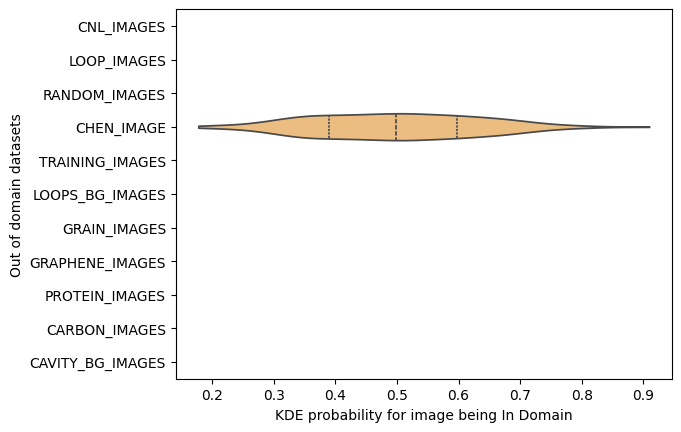

In [33]:
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
import glob

import pandas as pd

# Creating a new DataFrame with two columns: 'file_name' and 'KDE_prob'
kde_chen_df = pd.DataFrame(columns=['file_name', 'KDE_prob'])

RANDOM_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/random_images'
LOOPS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/loops_images'
CHEN_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_chen'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_CNL_cleaned/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/val'
TRAIN_OVERFOCUS_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/train"
DISLOCATION_IMAGE_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/Line dislocation images"
GRAIN_NANOPARTICLES_IMAGE_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/GrainNanoparticles"
GRAPHENE_NANOPARTICLES_IMAGE_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/GrapheneNanoparticles"
PROTEIN_NANOPARTICLES_IMAGE_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/ProteinNanoparticles"
CARBON_NANOPARTICLES_IMAGE_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/CarbonNanoparticles"
USABLE_IMAGES_PATH = "/Users/vidit/Documents/Image-domain/Cavity_images/Usable Imgs"

TRAIN_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/train'
TRAIN_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/train'

#Get all the vectors for the in domain images from the dictionary
#all_vectors = latent_spaces_dict['IN_DOMAIN']

file_paths_underfocus = glob.glob(TRAIN_UNDERFOCUS_IMAGE_PATH + "/*")
file_paths_overfocus = glob.glob(TRAIN_OVERFOCUS_IMAGE_PATH + "/*")
file_paths = file_paths_underfocus + file_paths_overfocus

#Do a revolving 5-fold cross validation for the all_images

# Generating indices for the tensor
indices = [i for i in range(len(file_paths))]

# Function to split indices for cross-validation
def cross_validation_split_indices(indices, num_folds):
    fold_size = len(indices) // num_folds
    folds_indices = []

    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size if i != num_folds - 1 else len(indices)
        validation_indices = indices[start:end]
        train_indices = indices[:start] + indices[end:]
        folds_indices.append((train_indices, validation_indices))

    return folds_indices

# Performing the 5-fold cross-validation split using indices
folds_indices = cross_validation_split_indices(indices, 5)

ID_kde_scores = []
'''

for i in range(5):
  selected_file_paths_test = [file_paths[i] for i in folds_indices[i][1]]
  selected_file_paths_train = [file_paths[i] for i in folds_indices[i][0]]


  all_indomain_train_latentspaces = torch.zeros(0)
  for j in range(0, len(selected_file_paths_train)):
    image_tensor = load_resize_and_divide_image(selected_file_paths_train[j])
    image_tensor = image_tensor.permute(0, 3, 1, 2)
    in_domain_load_train = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)

    with torch.no_grad():
      for batch_features in in_domain_load_train:
        predict_outputs, outdomain_latentspaces = predict_model(batch_features)
        outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
        all_indomain_train_latentspaces = torch.cat((all_indomain_train_latentspaces, outdomain_latentspaces.cpu()))

  kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(all_indomain_train_latentspaces)
  
  for k in range(0, len(selected_file_paths_test)):
    image_tensor = load_resize_and_divide_image(selected_file_paths_test[k])
    image_tensor = image_tensor.permute(0, 3, 1, 2)
    in_domain_load_test = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
    all_indomain_test_latentspaces = torch.zeros(0)
    with torch.no_grad():
      for batch_features in in_domain_load_test:
        predict_outputs, outdomain_latentspaces = predict_model(batch_features)
        outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
        all_indomain_test_latentspaces = torch.cat((all_indomain_test_latentspaces, outdomain_latentspaces.cpu()))
    log_density = kde.score_samples(all_indomain_test_latentspaces)
    max_log_density = np.max(log_density)
    min_log_density = np.min(log_density)
    max_in = np.max(log_density)
    trans = lambda x: np.exp(x-max_in)

    probs = trans(log_density)
    probs.sort()
    #Take the mean of the probs
    #print("Mean for the below image: ", probs.mean())
    #plt.yscale("log")
    #plt.bar(torch.arange(0, all_outdomain_latentspaces.size()[0]), probs)
    #plt.show()

    ID_kde_scores.append(probs.mean())

print("Mean ID KDE Scores: ", sum(ID_kde_scores)/len(ID_kde_scores))

'''
  
#Predicting the 16 dimensional vectors for the all_images
#How to make it so that you can use the model evalution on the all_vectors



all_vectors = torch.zeros(0)
all_outputs = torch.zeros(0)
with torch.no_grad():
  for batch_features in image_load:
    predict_outputs, latent_vector = predict_model(batch_features.to(device))
    latent_vector = latent_vector.view(batch_features.size()[0], -1)
    all_vectors = torch.cat((all_vectors, latent_vector.cpu()))
    all_outputs = torch.cat((all_outputs, predict_outputs.cpu()))


print(all_vectors.size())
kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(all_vectors)

log_density = kde.score_samples(all_vectors)

max_in = np.max(log_density)
trans = lambda x: np.exp(x-max_in)

log_train = trans(log_density)
log_train.sort()
print("Printing the starting training images")
plt.yscale("log")
plt.bar(torch.arange(0, all_vectors.size()[0]), log_train)
plt.show()

latent_spaces_dict = {}

#Define the dictionary
Fractions = {"CNL_IMAGES":[], "LOOP_IMAGES":[], "RANDOM_IMAGES":[], "CHEN_IMAGE":[], "TRAINING_IMAGES":[],
             "LOOPS_BG_IMAGES": [],
             "GRAIN_IMAGES": [], "GRAPHENE_IMAGES": [], "PROTEIN_IMAGES": [], "CARBON_IMAGES": [], "CAVITY_BG_IMAGES": []}
Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_IMAGES", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", 
             CHEN_IMAGE_PATH: "CHEN_IMAGE", VAL_UNDERFOCUS_IMAGE_PATH: "TRAINING_IMAGES", TRAIN_OVERFOCUS_PATH: "OVERFOCUS_IMAGES", VAL_OVERFOCUS_IMAGE_PATH: "TRAINING_IMAGES",
             DISLOCATION_IMAGE_PATH: "LOOPS_BG_IMAGES", GRAIN_NANOPARTICLES_IMAGE_PATH: "GRAIN_IMAGES", 
             GRAPHENE_NANOPARTICLES_IMAGE_PATH: "GRAPHENE_IMAGES", PROTEIN_NANOPARTICLES_IMAGE_PATH: "PROTEIN_IMAGES",
             CARBON_NANOPARTICLES_IMAGE_PATH: "CARBON_IMAGES", USABLE_IMAGES_PATH: "CAVITY_BG_IMAGES"}

Fractions["TRAINING_IMAGES"] = ID_kde_scores

for imagepath in [CHEN_IMAGE_PATH]:
  filename  = glob.glob(imagepath + "/*")
  if Name_dict[imagepath] not in latent_spaces_dict:
    latent_spaces_dict[Name_dict[imagepath]] = torch.zeros(0)
  for i in range(0, len(filename)):
    image_tensor = load_resize_and_divide_image(filename[i])
    image_tensor = image_tensor.permute(0, 3, 1, 2)

    outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
    all_outdomain_latentspaces = torch.zeros(0)
    with torch.no_grad():
      for batch_features in outdomain_load:
        predict_outputs, outdomain_latentspaces = predict_model(batch_features)
        outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
        all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))
    log_density = kde.score_samples(all_outdomain_latentspaces.detach().numpy())
    probs = trans(log_density)
    #Take the mean of the probs
    #print("Mean for the below image: ", probs.mean())
    probs.sort()
    '''
    if Name_dict[imagepath] == "CHEN_IMAGE":
      print(f"Printing the {filename[i]} image")
      plt.yscale("log")
      plt.bar(torch.arange(0, all_outdomain_latentspaces.size()[0]), probs)
      plt.show()
    '''
    Fractions[Name_dict[imagepath]].append(probs.mean())
    if Name_dict[imagepath] == "CHEN_IMAGE":
      new_row = pd.DataFrame({'file_name': [filename[i]], 'KDE_prob': [probs], 'image_path': [imagepath]})
      kde_chen_df = pd.concat([kde_chen_df, new_row], ignore_index=True)


#Make a violin plot for the different percentages for the Fractions dictionary
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl

fig, ax = pl.subplots()

df = pd.DataFrame({key: pd.Series(value) for key, value in Fractions.items()})
#Set x and y labels
ax.set_xlabel("KDE probability for image being In Domain")
ax.set_ylabel("Out of domain datasets")

g = sns.violinplot(data=df, ax=ax, palette='Spectral', cut=0, scale='width', inner='quartile', orient="h")
pl.show()

#Make df a csv file
kde_chen_df.to_csv('KDE_probabilities_chen.csv', index=False)

{'CNL_IMAGES': [0.2217768685764222, 0.29487169097635435, 0.281301406096626, 0.3392611512944309, 0.23689233876082058, 0.6782103772732038, 0.2753837958582821, 0.21887084287365283, 0.26613263636564216, 0.24080907550473074, 0.4001413349885013, 0.2616561237014112, 0.35192840142688886, 0.30824205136018445, 0.027274132350323034, 0.2626669911477265, 0.258407210632547, 0.21591895374103715, 0.2868629095320504, 0.35142091706890755, 0.26107821250559987, 0.2507925386302189, 0.2725532568369269, 0.32697416730781215, 0.30407301697544065, 0.2374206981307304, 0.07793861709957846, 0.3450274010513147, 0.38833418962458666, 0.3249492458472778, 0.3387277511092518, 0.2928840858831922, 0.29596678089026257, 0.33946933475560553, 0.3202441780750368, 0.39043572035900637, 0.4596795251612462, 0.2958984597049786, 0.3359893602173663, 0.35554587302059565, 0.43067867939636717, 0.29590738765489594, 0.3875255656413844, 0.3468054883462483, 0.364539012614391, 0.47093750968233195, 0.3378622260931306, 0.34815829715968044, 0.1

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

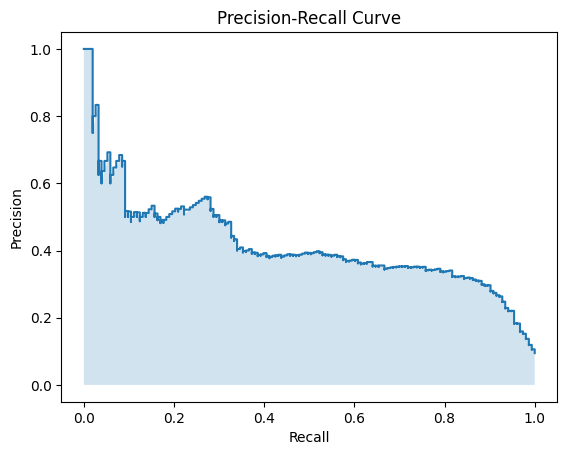

F1 0.4811133200795228 Precision 0.3457142857142857 Recall 0.7908496732026143
Threshold 0.5314822045779204


In [59]:
print(Fractions)
#Make a PR Curve for the different percentages for the Fractions dictionary
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import f1_score

# Plotting PR curves for each case with different cutoffs
plt.figure(figsize=(10, 8))

# Define different cutoffs to be analyzed
cutoffs = [0.6, 0.7, 0.8, 0.9]

print(Fractions.keys())

big_prob = []
labels = []

for key in Fractions:
    #if(key == "CHEN_IMAGE"):
    #    continue
    if key == "TRAINING_IMAGES":
        for i in range(len(Fractions[key])):
            labels.append(1)
            big_prob.append(Fractions[key][i])
    else:
        for i in range(len(Fractions[key])):
            labels.append(0)
            big_prob.append(Fractions[key][i])

precision, recall, thresholds = precision_recall_curve(labels, big_prob)

# Plot using PrecisionRecallDisplay
plt.figure(figsize=(10, 8))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.fill_between(recall, precision, alpha=0.2)
plt.title('Precision-Recall Curve')
plt.show()


# Calculate F1 scores for each pair of precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the maximum F1 score
max_f1_score = np.max(f1_scores)
max_f1_score_index = np.argmax(f1_scores)
max_precision = precision[max_f1_score_index]
max_recall = recall[max_f1_score_index]

print("F1", max_f1_score, "Precision", max_precision, "Recall", max_recall)
print("Threshold", thresholds[max_f1_score_index])

In [60]:
# Calculate accuracy for each threshold
accuracy_scores = []
for threshold in thresholds:
    # Convert probabilities to binary labels based on the threshold
    predicted_labels = [1 if prob >= threshold else 0 for prob in big_prob]
    accuracy = accuracy_score(labels, predicted_labels)
    accuracy_scores.append(accuracy)

# Find the maximum accuracy score and its corresponding threshold
max_accuracy_score = np.max(accuracy_scores)
max_accuracy_score_index = np.argmax(accuracy_scores)
max_accuracy_threshold = thresholds[max_accuracy_score_index]

print("Maximum Accuracy Score:", max_accuracy_score)
print("Threshold for Maximum Accuracy:", max_accuracy_threshold)

Maximum Accuracy Score: 0.9108910891089109
Threshold for Maximum Accuracy: 0.7256395634173132


In [1]:
#calculating the AUC for the PR curve
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print("AUC for the PR curve: ", auc_score)


NameError: name 'recall' is not defined

This section is going to make UMAPS for when we average for every single point with the points.

In [72]:
# Calculating the vectors for all the out of domain images now
# Create a dictionary to store the variables

latent_spaces_dict = {}
import random



RANDOM_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/random_images'
LOOPS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/loops_images'
CHEN_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_chen'
CNL_UNDEROVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_CNL_cleaned/train'
VAL_UNDERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_underfocus_only/val'
VAL_OVERFOCUS_IMAGE_PATH = '/Users/vidit/Documents/Image-domain/Cavity_images/cavity_nome_overfocus_only/val'

Name_dict = {CNL_UNDEROVERFOCUS_IMAGE_PATH: "CNL_IMAGES", LOOPS_IMAGE_PATH: "LOOP_IMAGES", RANDOM_IMAGE_PATH: "RANDOM_IMAGES", 
             CHEN_IMAGE_PATH: "CHEN_IMAGE", VAL_UNDERFOCUS_IMAGE_PATH: "IN_DOMAIN", VAL_OVERFOCUS_IMAGE_PATH: "IN_DOMAIN"}
for imagepath in [RANDOM_IMAGE_PATH, LOOPS_IMAGE_PATH, CHEN_IMAGE_PATH, CNL_UNDEROVERFOCUS_IMAGE_PATH, VAL_UNDERFOCUS_IMAGE_PATH, VAL_OVERFOCUS_IMAGE_PATH]:
  filename  = glob.glob(imagepath + "/*")
  if Name_dict[imagepath] not in latent_spaces_dict:
    latent_spaces_dict[Name_dict[imagepath]] = torch.zeros(0)
  if Name_dict[imagepath] == "IN_DOMAIN":
    for i in range(8):
      image_tensor = load_resize_and_divide_image(filename[random.randint(0, len(filename) - 1)])
      image_tensor = image_tensor.permute(0, 3, 1, 2)

      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))


        all_outdomain_latentspaces = torch.mean(all_outdomain_latentspaces, dim=0, keepdim=True)
        latent_spaces_dict[Name_dict[imagepath]] = torch.cat((latent_spaces_dict[Name_dict[imagepath]], all_outdomain_latentspaces))
        print(latent_spaces_dict[Name_dict[imagepath]].size())

  else:
    for i in range(16):
      image_tensor = load_resize_and_divide_image(filename[random.randint(0, len(filename) - 1)])
      image_tensor = image_tensor.permute(0, 3, 1, 2)

      outdomain_load = torch.utils.data.DataLoader(image_tensor, batch_size=16, shuffle=False)
      all_outdomain_latentspaces = torch.zeros(0)
      with torch.no_grad():
        for batch_features in outdomain_load:
          predict_outputs, outdomain_latentspaces = predict_model(batch_features)
          outdomain_latentspaces = outdomain_latentspaces.view(outdomain_latentspaces.size()[0], -1)
          all_outdomain_latentspaces = torch.cat((all_outdomain_latentspaces, outdomain_latentspaces.cpu()))
      all_outdomain_latentspaces = torch.mean(all_outdomain_latentspaces, dim=0, keepdim=True)
      latent_spaces_dict[Name_dict[imagepath]] = torch.cat((latent_spaces_dict[Name_dict[imagepath]], all_outdomain_latentspaces))
      print(latent_spaces_dict[Name_dict[imagepath]].size())

print(latent_spaces_dict.keys())

torch.Size([1, 16])
torch.Size([2, 16])
torch.Size([3, 16])
torch.Size([4, 16])
torch.Size([5, 16])
torch.Size([6, 16])
torch.Size([7, 16])
torch.Size([8, 16])
torch.Size([9, 16])
torch.Size([10, 16])
torch.Size([11, 16])
torch.Size([12, 16])
torch.Size([13, 16])
torch.Size([14, 16])
torch.Size([15, 16])
torch.Size([16, 16])
torch.Size([1, 16])
torch.Size([2, 16])
torch.Size([3, 16])
torch.Size([4, 16])
torch.Size([5, 16])
torch.Size([6, 16])
torch.Size([7, 16])
torch.Size([8, 16])
torch.Size([9, 16])
torch.Size([10, 16])
torch.Size([11, 16])
torch.Size([12, 16])
torch.Size([13, 16])
torch.Size([14, 16])
torch.Size([15, 16])
torch.Size([16, 16])
torch.Size([1, 16])
torch.Size([2, 16])
torch.Size([3, 16])
torch.Size([4, 16])
torch.Size([5, 16])
torch.Size([6, 16])
torch.Size([7, 16])
torch.Size([8, 16])
torch.Size([9, 16])
torch.Size([10, 16])
torch.Size([11, 16])
torch.Size([12, 16])
torch.Size([13, 16])
torch.Size([14, 16])
torch.Size([15, 16])
torch.Size([16, 16])
torch.Size([1, 16])

(80, 16)


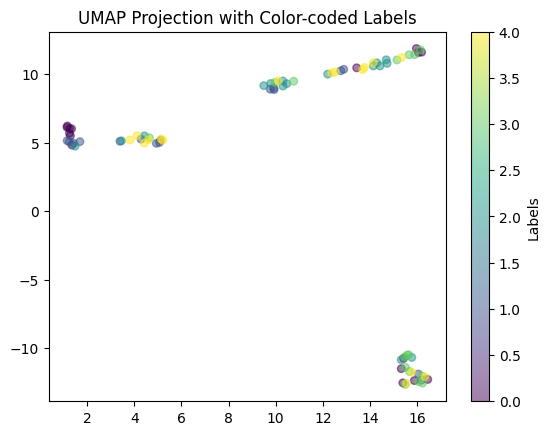

In [73]:
#Perform UMAP on these data points
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(["Randoms"] * len(latent_spaces_dict['RANDOM_IMAGES']) +
                  ["Loops"] * len(latent_spaces_dict['LOOP_IMAGES']) +
                  ["CNL"] * len(latent_spaces_dict['CNL_IMAGES']) +
                  ["Chen"] * len(latent_spaces_dict['CHEN_IMAGE']) +
                  ["ID"] * len(latent_spaces_dict['IN_DOMAIN']))
all_data = np.concatenate((latent_spaces_dict['RANDOM_IMAGES'], latent_spaces_dict['LOOP_IMAGES'], latent_spaces_dict['CHEN_IMAGE'], latent_spaces_dict['CNL_IMAGES'], latent_spaces_dict['IN_DOMAIN']), axis=0)
print(all_data.shape)

#Dictionary with the data and labels
all_data_dict = {'data': all_data, 'labels': labels}

# Create a UMAP Model
umap_model = umap.UMAP()

# Convert string labels to numeric labels
label_dict = {'Randoms': 0, 'Loops': 1, 'CNL': 2, 'Chen': 3, 'ID': 4}
numeric_labels = np.array([label_dict[label] for label in labels])

# Fit the UMAP model to the data
umap_result = umap_model.fit_transform(all_data)

# Plot the UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=numeric_labels, cmap='viridis', s=30, alpha=0.5)
plt.title('UMAP Projection with Color-coded Labels')
plt.colorbar(label='Labels')
plt.show()



Accuracy: 0.2500
Precision: 0.3900
Recall: 0.2233


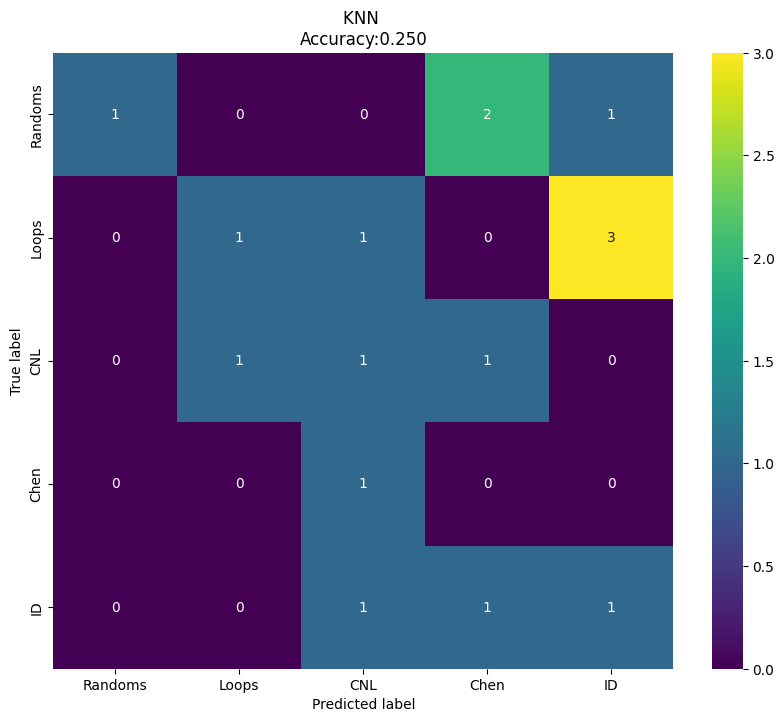

In [75]:
#Use Nearest Neighbors on the all_data_dict with the array values for all the 16 dimensional vectors with the different labels present

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_data_dict['data'], all_data_dict['labels'], test_size=0.2, random_state=42)

# Create a Nearest Neighbors model
n_neighbors = 8
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn_model.predict(X_test)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#Make the Confusion Matrix for the predictions
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of labels
labels = ['Randoms', 'Loops', 'CNL', 'Chen', 'ID']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Create a DataFrame from the confusion matrix  
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('KNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Divide the one big image into 256 sub images and then reconstruct the 256 images to make the one big image back

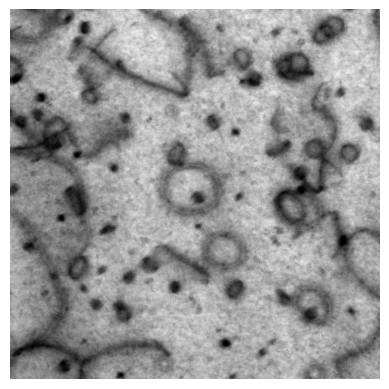

torch.Size([256, 64, 64, 1])
torch.Size([256, 1, 64, 64])
Big Output Image:  torch.Size([256, 1, 64, 64])
Latent Vector:  torch.Size([16, 16])
Part Image:  torch.Size([16, 1, 64, 64])
torch.Size([256, 1, 64, 64])


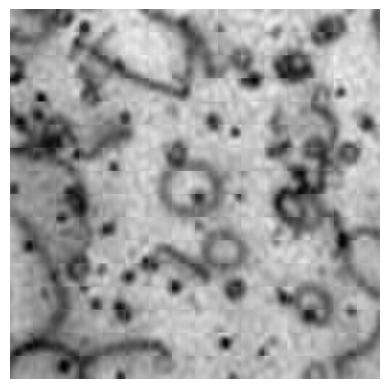

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Bear_image = "/Users/vidit/Documents/Image-domain/Cavity_images/loops_images/BF X500K, 02 (2).jpg"
im=Image.open(Bear_image)
# Load the image using matplotlib.image.imread
bear_image = mpimg.imread(Bear_image)

# Display the image
plt.imshow(bear_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


bear_image_division = load_resize_and_divide_image(Bear_image)
print(bear_image_division.size())
bear_image_division = bear_image_division.permute(0, 3, 1, 2)
print(bear_image_division.size())
load_one_image = torch.utils.data.DataLoader(bear_image_division, batch_size=16, shuffle=False)

big_output_vector = torch.zeros(0)
with torch.no_grad():
    for batch_features in load_one_image:
        predict_outputs, latent_vector = predict_model(batch_features.to(device))
        latent_vector = latent_vector.view(batch_features.size()[0], -1)
        big_output_vector = torch.cat((big_output_vector, predict_outputs.cpu()))
print("Big Output Image: ", big_output_vector.size())
print("Latent Vector: ", latent_vector.size())
print("Part Image: ", predict_outputs.size())

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def reverse_function(tensor_images):
    # Move the tensor images back to the default device
    tensor_images = tensor_images.to('cpu')
    # Reshape the tensor images to a 4D tensor
    print(tensor_images.size())
    tensor_images = tensor_images.view(16, 16, 64, 64, 1)

    # Create an empty array to store the blocks
    blocks = []

    # Iterate through the tensor images and convert each block back to a numpy array
    for i in range(16):
        for j in range(16):
            block = tensor_images[i, j].squeeze().numpy() * 255.0
            blocks.append(block)

    # Combine the blocks to reconstruct the resized image
    reconstructed_image = np.block([[blocks[i * 16 + j] for j in range(16)] for i in range(16)])

    # Convert the image back to uint8 type
    reconstructed_image = reconstructed_image.astype(np.uint8)

    # Resize the image back to its original size
    reconstructed_image = cv2.resize(reconstructed_image, (1024, 1024))

    # Display the image using matplotlib
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')
    plt.show()

reverse_function(big_output_vector)






           0         1         2         3         4         5         6  \
0   0.000053  0.000076  0.000103  0.002050  0.003728  0.006890  0.007958   
1   0.001953  0.005105  0.011277  0.011418  0.014613  0.026309  0.034119   
2   0.000037  0.000288  0.000328  0.000336  0.000509  0.000638  0.000990   
4   0.019950  0.040314  0.056359  0.065040  0.097480  0.109926  0.123927   
5   0.000211  0.001242  0.001355  0.001441  0.001522  0.001612  0.001973   
6   0.000655  0.001046  0.001131  0.001716  0.002139  0.002544  0.005276   
7   0.003054  0.006435  0.023308  0.023922  0.026766  0.030921  0.035090   
8   0.002279  0.004345  0.005924  0.009190  0.010326  0.012089  0.013956   
9   0.000565  0.006906  0.072590  0.103251  0.143903  0.145955  0.151178   
10  0.000060  0.000076  0.000316  0.000415  0.003850  0.020476  0.031194   

           7         8         9  ...       247       248       249       250  \
0   0.008923  0.009679  0.010683  ...  0.515866  0.517551  0.517933  0.520682   
1

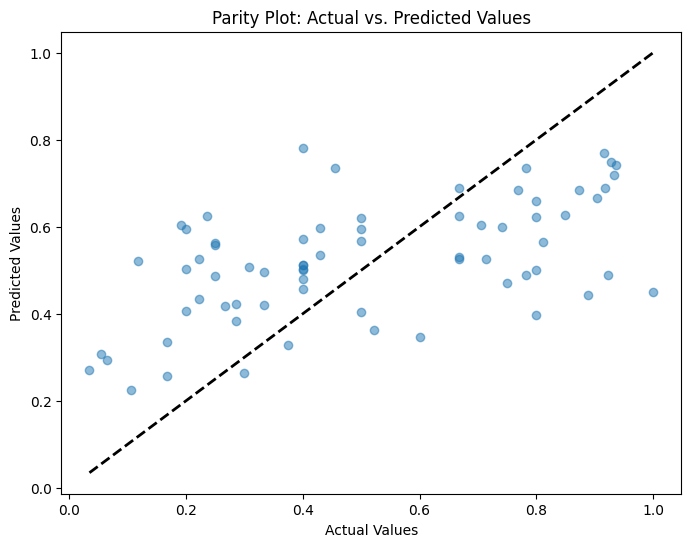

Mean Absolute Error (MAE): 0.19909993987618174
Mean Squared Error (MSE): 0.05287768203907708
Coefficient of Determination (R² score): 0.3013039263759745


In [35]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('KDE_probabilities_chen.csv')

# Extract image number
df['img'] = df['file_name'].str.extract(r'(\d{5}).png').astype(int)

# Split the KDE_prob string into separate numeric columns
kde_prob_columns = df['KDE_prob'].str.strip('[]').str.split(expand=True).astype(float)

# Combine the image number with the KDE_prob columns
df_combined_image = pd.concat([df['img'], kde_prob_columns], axis=1)


f1_score_df = pd.read_csv('Chen_kde_f1.csv')
f1_score_df = f1_score_df.drop(columns=['kde'])

#Merge the two dataframes together using inner join on the basis of img and image_number
df_combined_image = pd.merge(df_combined_image, f1_score_df, how = "inner", on='img')


df_combined_image.columns = df_combined_image.columns.astype(str)
df_combined_image = df_combined_image.dropna()
df_combined_image = df_combined_image.drop(columns=['img'])

print(df_combined_image.head(10))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined_image.drop(['f1'], axis=1), 
                                                    df_combined_image['f1'], 
                                                    test_size=0.2)

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate predictions
y_pred = rf.predict(X_test)

# Create a parity plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()

# Calculate statistics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R² score): {r2}")




In [37]:
df_combined_image.to_csv('KDE_probabilities_f1.csv', index=False)

In [28]:
import pandas as pd
import numpy as np

# Assuming 'df' is your original DataFrame with 256 columns
new_df_data = []

#df_combined_image
#print(df_combined_image.head(10))
#df_combined_image = df_combined_image.drop(['f1'], axis=1)

for index, row in df_combined_image.iterrows():
    # Split the row into 5 parts and calculate the mean of each part
    means = [np.mean(row[i:i + 51]) for i in range(0, 251, 51)]
    # Append the last few elements to the last group
    means.append(np.mean(row[255:]))
    new_df_data.append(means)

# Create a new DataFrame
new_df = pd.DataFrame(new_df_data, columns=['Group1_Mean', 'Group2_Mean', 'Group3_Mean', 'Group4_Mean', 'Group5_Mean'])

# new_df now contains the mean of each group for every row
new_df

ValueError: 5 columns passed, passed data had 6 columns